In [41]:
import seaborn as sns
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from process_data import process_mutation_data

%load_ext autoreload
%autoreload 2

from statistical_test import *
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
def violin_plot_for_mutation_distance(df, experiment_name, fig_name, split=True, inner='quart', density_norm='area', width=0.8, x_order=None):
    # tol palette, color-blind friendly
    plt.rcParams.update({'axes.edgecolor': 'black', 'axes.linewidth': 2, 'axes.grid': True, 'grid.linestyle': '--'})
    plt.rcParams['figure.figsize'] = 7, 3
    custom_palette = {'Zest-all': '#DD8452', 'Zest-saved': '#BEBADA', 'Zeugma-saved': '#BEBADA', 'EI-all': '#4C72B0', 'Zeugma-all': '#4C72B0', 'BeDivFuzz-all': '#4C72B0'}
    tmp_ax = sns.violinplot(data=df, x='benchmark_name', y='mutation_string', hue='algorithm',
                            split=split, inner=inner, density_norm=density_norm, palette=custom_palette,
                            width=width, linewidth=1.0, order=x_order, common_norm=True, saturation=1, dodge=True)
    sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False)
    for l in tmp_ax.lines:
        l.set_linestyle(':')
        l.set_linewidth(1)
        l.set_color('black')
        l.set_alpha(0.8)
    for l in tmp_ax.lines[1::3]:
        l.set_linestyle('-')
        l.set_linewidth(1.6)
        l.set_color('#F7F056')
        l.set_alpha(0.8)

    # get rid of ticks for empty columns (levels)
    if x_order:
        x_arr = np.array(x_order)
        position_arr = np.array(range(0, len(x_order)))
        positions = [p for p, order in zip(position_arr, x_arr) if 'NA' not in order]
        filtered_x = [e for e in list(x_order) if 'NA' not in e]
        tmp_ax.set_xticks(positions)
        tmp_ax.set_xticklabels(filtered_x)
        plt.xticks(rotation=30)

    tmp_ax.set(xlabel='Benchmark', ylabel='Mutation Distance (%)')
    # tmp_ax.grid(False)
    plt.savefig('./figs/{}_{}.pdf'.format(experiment_name, fig_name), bbox_inches='tight', pad_inches=0.1)

In [43]:
def box_plot_for_mutation_distance(df, experiment_name, fig_name):
    tmp_ax = sns.boxplot(data=df, x='benchmark_name', y='mutation', hue='algorithm')
    sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
    plt.savefig('./figs/{}_{}.png'.format(experiment_name, fig_name), dpi=300)

In [44]:
def beautify_stats_table(groupby):
    stats = groupby.describe()
    processed_stats = stats.loc[:, (slice(None), ['', 'count', '50%', 'mean', 'std', 'min', 'max'])].rename(columns={'50%':'median'})
    return processed_stats

def bar_plot_for_median_mutation_distance(stats_df, experiment_name, fig_name):
    # get the median values
    median_mutation_df = stats_df.loc[:, (slice(None), ['', 'median'])]
    # flatten the index
    median_mutation_df.columns = median_mutation_df.columns.get_level_values(0)
    # reorder the index
    # median_mutation_df = median_mutation_df.reindex([0, 5, 6, 1, 2, 3, 4, 7, 12, 13, 8, 9, 10, 11]).reset_index(drop=True)
    # bar plot
    tmp_ax = sns.barplot(median_mutation_df, x='benchmark_name', y='mutation', hue='algorithm')
    sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
    plt.savefig('./figs/{}_{}.png'.format(experiment_name, fig_name), dpi=300)

In [45]:
# statistical tests
def mann_whitney_u_test_for_mutation_distance(df, groupby, alg1_name, alg2_name):
    # TODO: remove either df or groupby
    result_dict = {}
    test_names = ['two-sided', 'less']
    measures = ['p', 'A_12', 'U1', 'U2', 'r1', 'r2']
    indices = []
    for name in test_names:
        indices += ['{}_{}'.format(name, measure) for measure in measures]

    # Warning: large and unequal sample sizes will result in timeout; debugging required
    for benchmark_name in df.benchmark_name.unique():
        print('testing {}...'.format(benchmark_name))
        alg1_data = groupby.get_group((alg1_name, benchmark_name)).mutation.values
        alg2_data = groupby.get_group((alg2_name, benchmark_name)).mutation.values
        print('sample1 size: {}, sample2 size: {}'.format(len(alg1_data), len(alg2_data)))
        result_two_sided = mann_whitney_u_test(alg1_data, alg2_data, alternative=test_names[0], verbose=False)
        result_one_sided = mann_whitney_u_test(alg1_data, alg2_data, alternative=test_names[1], verbose=False)
        result_dict[benchmark_name] = list(result_two_sided) + list(result_one_sided)
    # create the dataframe
    stats_df = pd.DataFrame(result_dict, index=indices)
    return stats_df

In [48]:
process_mutation_data("/data/aoli/havoc_eval/havoc-dist", [False, True], ["random", "zest-mini", "zest", "ei", "bedivfuzz-simple", "bedivfuzz-structure", "zeugma-linked"], 'mutations')
# process_mutation_data("/data/aoli/havoc_eval/havoc-test", [False, True], ["zest", "ei", "bedivfuzz-simple", "bedivfuzz-structure", "zeugma-linked"], 'mutation_byte', "byte_")

/home/vasumv/zeugma/scripts/process_data.py:112: SyntaxWarning: invalid escape sequence '\#'
  axis.set(ylabel = "\# Increased Branch Coverage")


ant random
ant random
ant zest-mini
ant zest-mini
ant zest
ant zest
ant ei
ant ei
ant bedivfuzz-simple
ant bedivfuzz-simple
ant bedivfuzz-structure
ant bedivfuzz-structure
ant zeugma-linked
ant zeugma-linked
processing ant...
maven random
maven random
maven zest-mini
maven zest-mini
maven zest
maven zest
maven ei
maven ei
maven bedivfuzz-simple
maven bedivfuzz-simple
maven bedivfuzz-structure
maven bedivfuzz-structure
maven zeugma-linked
maven zeugma-linked
processing maven...
rhino random
rhino random
rhino zest-mini
rhino zest-mini
rhino zest
rhino zest
rhino ei
rhino ei
rhino bedivfuzz-simple
rhino bedivfuzz-simple
rhino bedivfuzz-structure
rhino bedivfuzz-structure
rhino zeugma-linked
rhino zeugma-linked
processing rhino...
closure random
closure random
closure zest-mini
closure zest-mini
closure zest
closure zest
closure ei
closure ei
closure bedivfuzz-simple
closure bedivfuzz-simple
closure bedivfuzz-structure
closure bedivfuzz-structure
closure zeugma-linked
closure zeugma-linke

In [49]:
mutation_df = pd.read_pickle("./mutations.pkl")
new_label_names = {
    'zest': 'Zest',
    'zest-saved_only': 'Zest-saved',
    'ei': 'EI',
    'ei-saved_only': 'EI-saved',
    'zeugma-linked': 'Zeugma',
    'zeugma-linked-saved_only': 'Zeugma-saved',
    'bedivfuzz-structure': 'BeDivFuzz',
    'bedivfuzz-structure-saved_only': 'BeDivFuzz-saved',
    'random-saved_only': 'Random-saved',
    'random': 'Random',
    'zest-mini': 'Zest-Mini',
    'zest-mini-saved_only': 'Zest-Mini-saved'
    }
mutation_df['algorithm'] = mutation_df['algorithm'].map(new_label_names)
display(mutation_df[mutation_df.isna().any(axis=1)])

mutation_df = mutation_df.dropna()
zest_df = mutation_df[mutation_df['algorithm'].str.contains('Zest')]
# ei_df = mutation_df[~mutation_df.index.isin(zest_df.index)]
all_input_df = mutation_df[~mutation_df['algorithm'].str.contains('saved')]

mutation_bytes  mutation_string     algorithm  current_len  \
359914         0.234375         0.294118           NaN          168   
359915         0.281250         0.224852           NaN          169   
359916         0.312500         0.414634           NaN          164   
359917         0.390625         0.410811           NaN          185   
359918         0.333333         0.456376           NaN          253   
...                 ...              ...           ...          ...   
3179531        0.855707         0.899160  Zeugma-saved         1785   
3179539        0.050967         0.039683  Zeugma-saved          252   
3179542        0.158070         0.262745  Zeugma-saved          255   
3179564        0.449912         0.606426  Zeugma-saved          184   
3179666        0.949013         1.000000  Zeugma-saved            0   

         parent_len  saved  parent   result parent_result benchmark_name  
359914          187  False      34  SUCCESS       SUCCESS            ant  
359915          157  False      73  INVALID           NaN            ant  
359916          155  False      61  INVALID           NaN            ant  
359917          157  False     115  INVALID       SUCCESS            ant  
359918          298  False     266  INVALID       SUCCESS            ant  
...             ...    ...     ...      ...           ...            ...  
3179531         249   True       0  SUCCESS           NaN        jackson  
3179539         249   True       0  SUCCESS           NaN        jackson  
3179542         249   True       0  SUCCESS           NaN        jackson  
3179564         249   True       0  SUCCESS           NaN        jackson  
3179666         249   True       0  FAILURE           NaN        jackson  

[557794 rows x 10 columns]

In [50]:
all_input_df

mutation_bytes  mutation_string algorithm  current_len  parent_len  \
0              0.967742         0.447761    Random           93         134   
1              0.964286         0.568750    Random          160         151   
2              0.986111         0.587065    Random          201         178   
3              0.972222         0.544944    Random          126         178   
4              0.984127         0.601124    Random           82         178   
...                 ...              ...       ...          ...         ...   
3179512        0.987034         0.986125    Zeugma         1009          14   
3179513        0.885572         0.876033    Zeugma          121          18   
3179514        0.859935         0.855346    Zeugma          159          30   
3179515        0.972021         0.960352    Zeugma          454          19   
3179516        0.972028         0.968121    Zeugma          596          19   

         saved  parent   result parent_result benchmark_name  
0        False      23  INVALID       SUCCESS            ant  
1        False      41  INVALID       SUCCESS            ant  
2        False      40  INVALID       SUCCESS            ant  
3        False      40  INVALID       SUCCESS            ant  
4        False      50  INVALID       SUCCESS            ant  
...        ...     ...      ...           ...            ...  
3179512  False    1547  SUCCESS       SUCCESS        jackson  
3179513  False    7310  SUCCESS       SUCCESS        jackson  
3179514  False   12437  SUCCESS       SUCCESS        jackson  
3179515  False   12169  SUCCESS       SUCCESS        jackson  
3179516  False   20606  SUCCESS       SUCCESS        jackson  

[2602498 rows x 10 columns]

In [51]:
non_zero_mutation_df = mutation_df[mutation_df['mutation_string'] != 0]
non_zero_zest_df = non_zero_mutation_df[mutation_df['algorithm'].str.contains('Zest')]
non_zero_all_input_df = non_zero_mutation_df[mutation_df['algorithm'].str.contains('all')]

# Filter out inputs with zero length
all_input_df_nonzero_len = all_input_df[(all_input_df['parent_len'] != 0) & (all_input_df['current_len'] != 0)]

/tmp/ipykernel_1140502/177115576.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_zero_zest_df = non_zero_mutation_df[mutation_df['algorithm'].str.contains('Zest')]
/tmp/ipykernel_1140502/177115576.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_zero_all_input_df = non_zero_mutation_df[mutation_df['algorithm'].str.contains('all')]


mutation_bytes  mutation_string algorithm  current_len  parent_len  \
541747         0.944020         1.000000    Zeugma            0          89   
541748         0.986586         1.000000    Zeugma            0          89   
541749         0.600000         0.404580    Zeugma          131          89   
541750         0.978206         1.000000    Zeugma            0         106   
541751         0.600000         0.404580    Zeugma          131          89   
...                 ...              ...       ...          ...         ...   
2950133        0.857143         0.894737    Zeugma            2          19   
2950134        0.450000         0.814815    Zeugma           27           8   
2950135        0.400000         0.807692    Zeugma            9          26   
2950136        0.770492         0.857143    Zeugma           42           7   
2950137        0.450000         0.821429    Zeugma           28           7   

         saved  parent parent_result benchmark_name  
541747    True       2       SUCCESS            ant  
541748    True       2       SUCCESS            ant  
541749    True       2       SUCCESS            ant  
541750    True       1       SUCCESS            ant  
541751    True       2       SUCCESS            ant  
...        ...     ...           ...            ...  
2950133  False   23661       SUCCESS        jackson  
2950134  False    1788       SUCCESS        jackson  
2950135  False    3652       SUCCESS        jackson  
2950136  False    2425       SUCCESS        jackson  
2950137  False    1328       SUCCESS        jackson  

[346052 rows x 9 columns]

<!-- # Mutation Distance (Bytes) -->

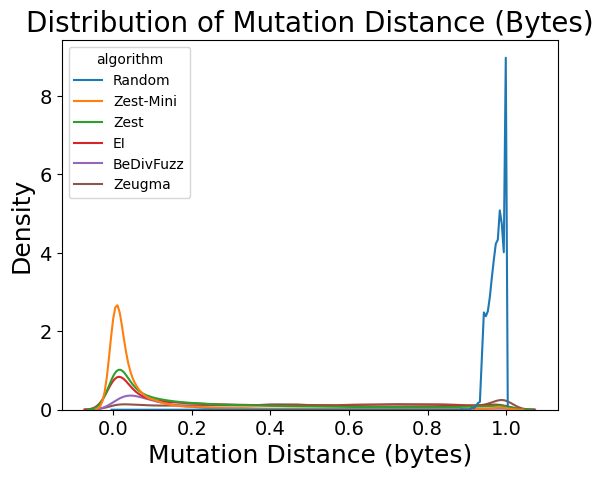

In [52]:
# Function to plot kde for mutation_byte for all algorithms
def plot_kde_for_mutation_byte(df, fig_name):
    plt.rcParams.update({'axes.edgecolor': 'black', 'axes.linewidth': 2, 'axes.grid': True, 'grid.linestyle': '--'})
    plt.rcParams['figure.figsize'] = 7, 3
    plt.style.use("default")
    plt.title("Distribution of Mutation Distance (Bytes)", fontsize=20)
    custom_palette = {'Zest-all': '#DD8452', 'Zest-saved': '#BEBADA', 'Zeugma-saved': '#BEBADA', 'EI-all': '#4C72B0', 'Zeugma-all': '#4C72B0', 'BeDivFuzz-all': '#4C72B0'}
    ax = sns.kdeplot(data=df, x='mutation_bytes', hue='algorithm', bw_adjust=1.0)

    ax.set_xlabel('Mutation Distance (bytes)', fontsize=18)
    ax.set_ylabel('Density', fontsize=18)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    plt.savefig('./figs/{}.pdf'.format(fig_name), bbox_inches='tight', pad_inches=0.1)
    # plt.savefig('./figs/{}_{}.pdf'.format(experiment_name, fig_name), bbox_inches='tight', pad_inches=0.1)

plot_kde_for_mutation_byte(all_input_df, 'mutation_byte_density')

# Mutation Distance (Byte vs String)

In [53]:

# Define a color palette
palette = sns.color_palette("husl", 6)  # "husl" generates distinct colors

colors = {"Zest": palette[0], "BeDivFuzz": palette[1], "EI": palette[2], "Zeugma": palette[3], "Random": palette[4], "Zest-Mini": palette[5]}

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tqdm

def plot_mut_distance_scatter(df, benchmark_name):
    """
    Create scatter plots of mutation distances arranged in 2 rows with 3 plots per row.

    Parameters:
    df (pandas.DataFrame): DataFrame containing mutation data with columns:
        - mutation_bytes
        - mutation_string
        - algorithm
        - benchmark_name
    benchmark_name (str): Name of the benchmark to plot

    Returns:
    matplotlib.figure.Figure: The generated plot
    """
    # Filter data for the specified benchmark
    plot_data = df[df['benchmark_name'] == benchmark_name].copy()
    plt.style.use("default")
    
    # Get unique algorithms
    algorithms = plot_data['algorithm'].unique()
    num_algorithms = len(algorithms)

    # Define a color palette
    colors = ['#4878CF', '#EE854A', '#D65F5F', '#59A14F', '#B279A2', '#BAB0AC']

    # Calculate rows and columns for the subplots
    rows = 2
    cols = 3
    
    # Create subplots with 2 rows and 3 columns
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)

    fig.suptitle(f'Mutation Distance of each Technique ({benchmark_name})', fontsize=24, y=0.98)

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    # Plot each algorithm separately with a different color
    for i, (algo, color) in enumerate(zip(algorithms, colors)):
        if i < len(axes):  # Ensure we don't go beyond available axes
            ax = axes[i]
            algo_data = plot_data[plot_data['algorithm'] == algo]
            sns.regplot(
                data=algo_data,
                x='mutation_bytes',
                y='mutation_string',
                scatter=True,
                scatter_kws={'s': 1, 'alpha': 0.5, 'color': color},  # Set scatter color
                line_kws={'color': color},  # Set trendline color
                ci=95,
                ax=ax
            )
            ax.set_title(f'{algo}', fontsize=20)  # Title in matching color
            ax.set_xlabel('Mutation Distance (bytes)', fontsize=18)
            ax.set_ylabel('Mutation Distance (string)', fontsize=18)
            ax.xaxis.set_tick_params(labelsize=14)
            ax.yaxis.set_tick_params(labelsize=14)
            ax.set_ylim(0, 1)
            ax.set_xlim(0, 1)
    
    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    # Adjust layout
    plt.tight_layout()
    return fig

# Generate the plot
# fig = plot_mut_distance_scatter(all_input_df_nonzero_len, "closure")
plt.savefig("figs/mutation_distance_scatter_closure.pdf", dpi=300, bbox_inches='tight')
for benchmark in tqdm.tqdm(all_input_df_nonzero_len['benchmark_name'].unique()):
    fig = plot_mut_distance_scatter(all_input_df, benchmark)
    plt.savefig(f"figs/scatter/mutation_distance_scatter_{benchmark}.pdf", dpi=300, bbox_inches='tight')

100%|█████████████████████████████████████████████| 7/7 [01:32<00:00, 13.17s/it]


<Figure size 640x480 with 0 Axes>

100%|████████████████████████████████████████████| 7/7 [16:00<00:00, 137.22s/it]


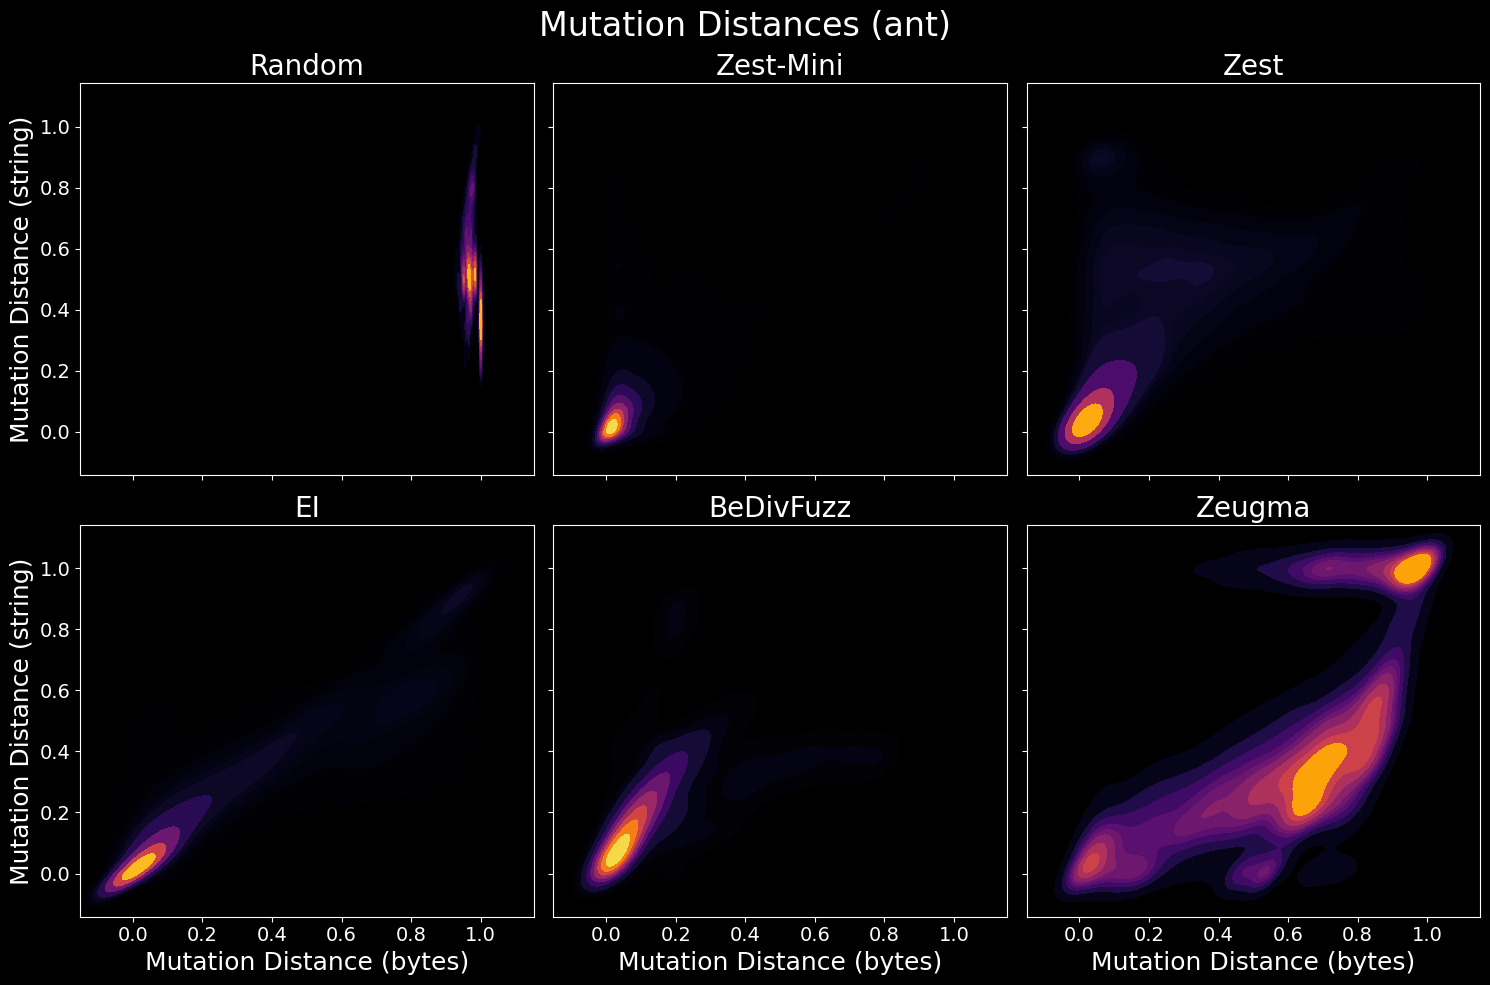

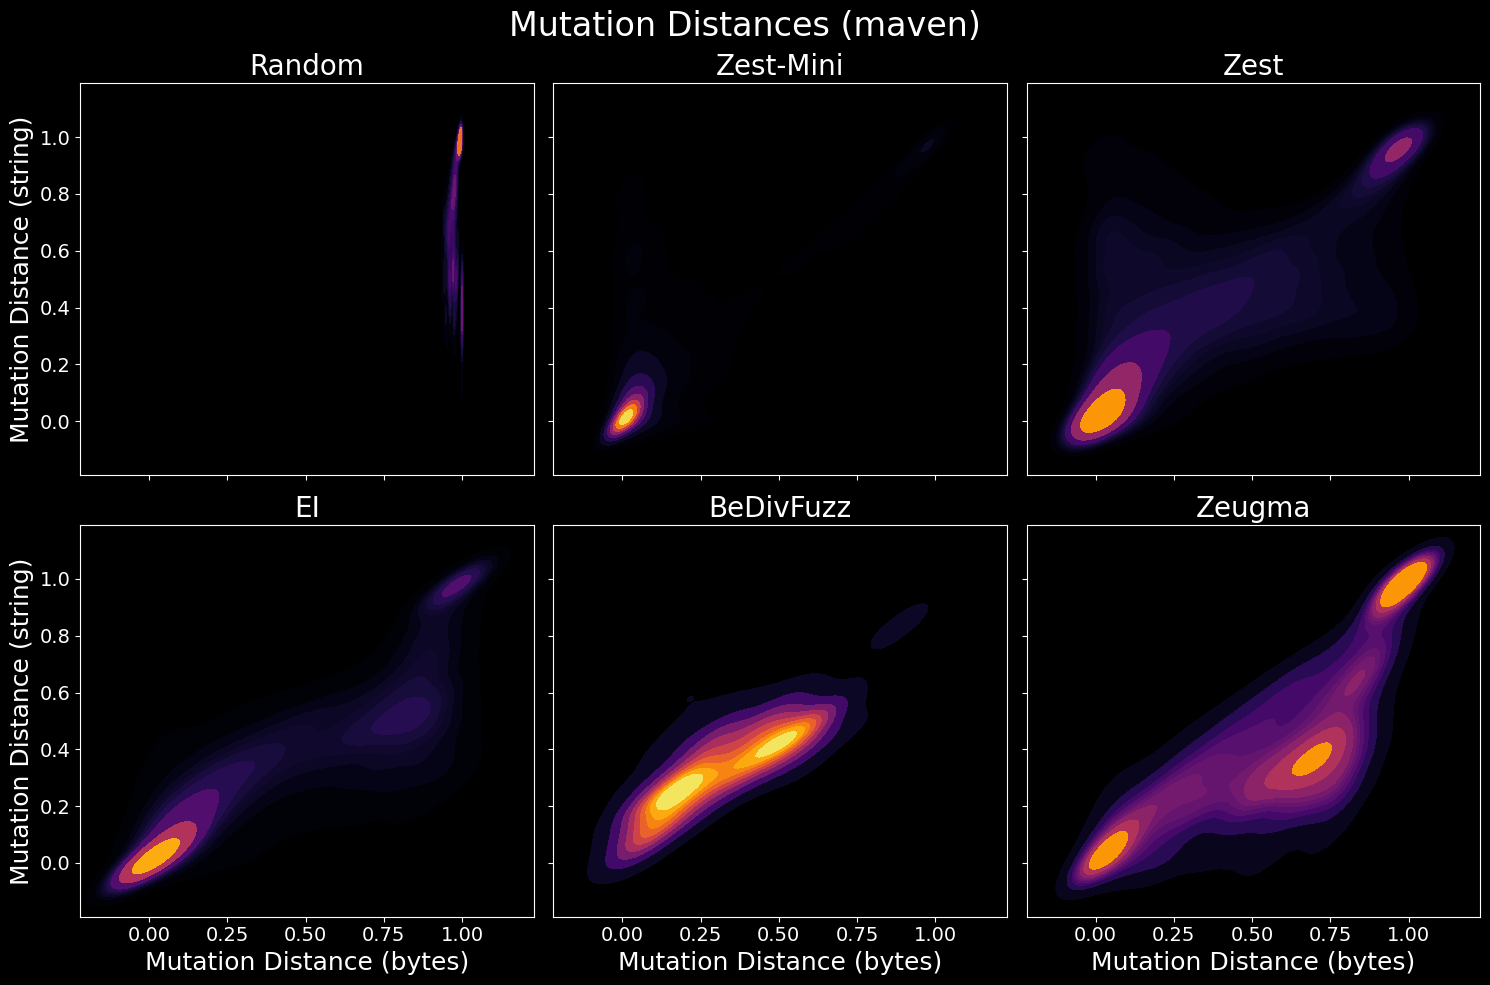

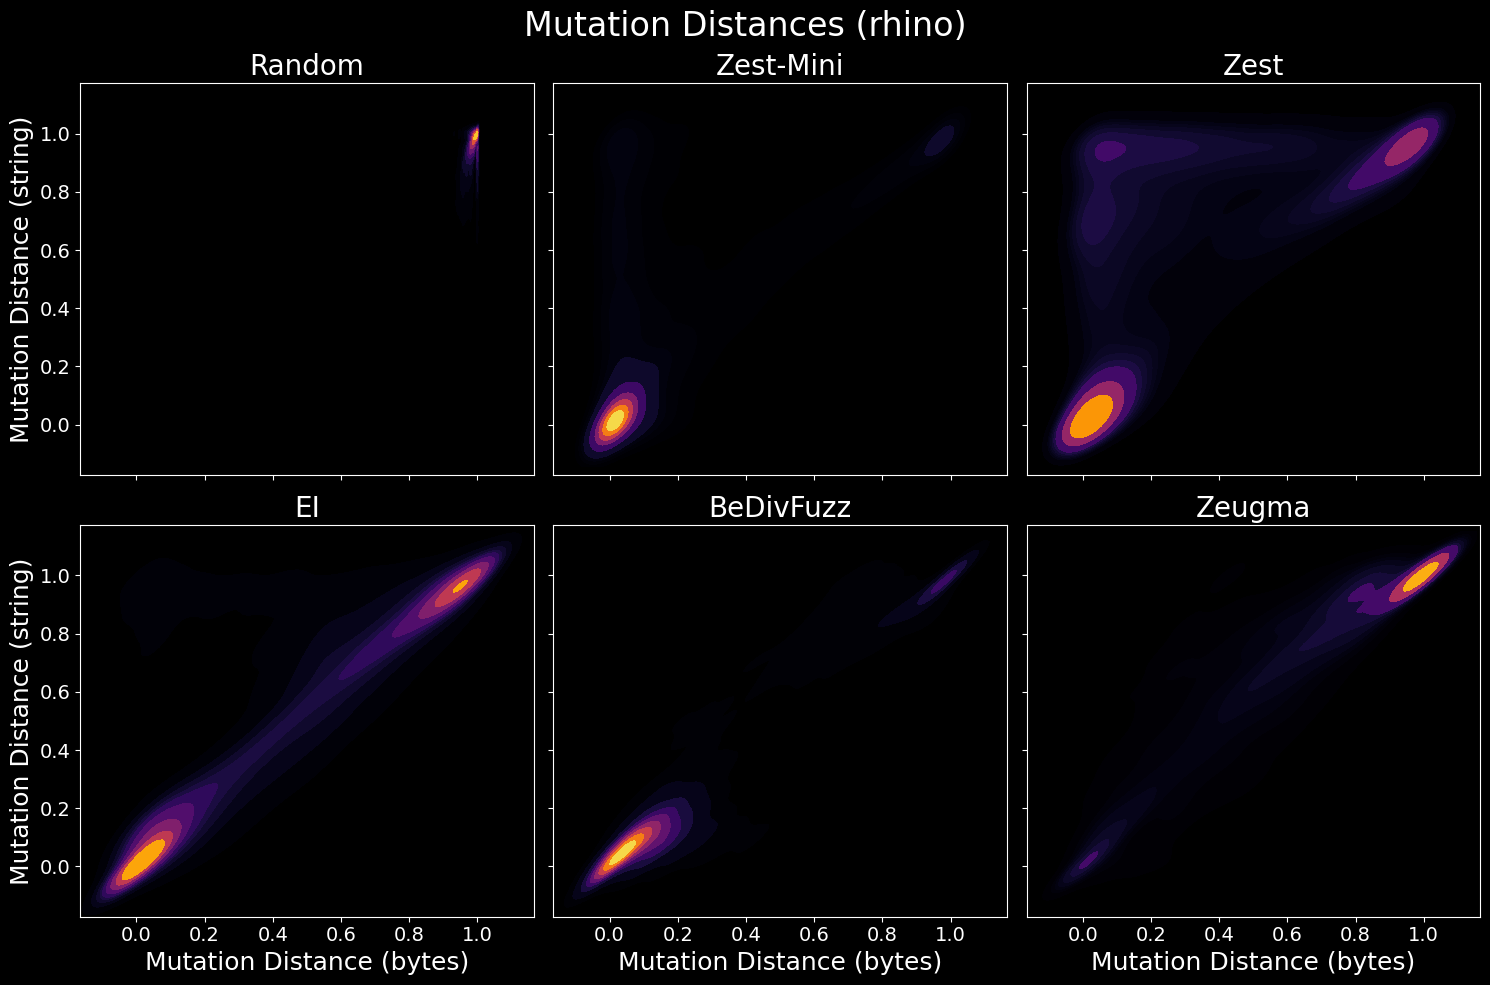

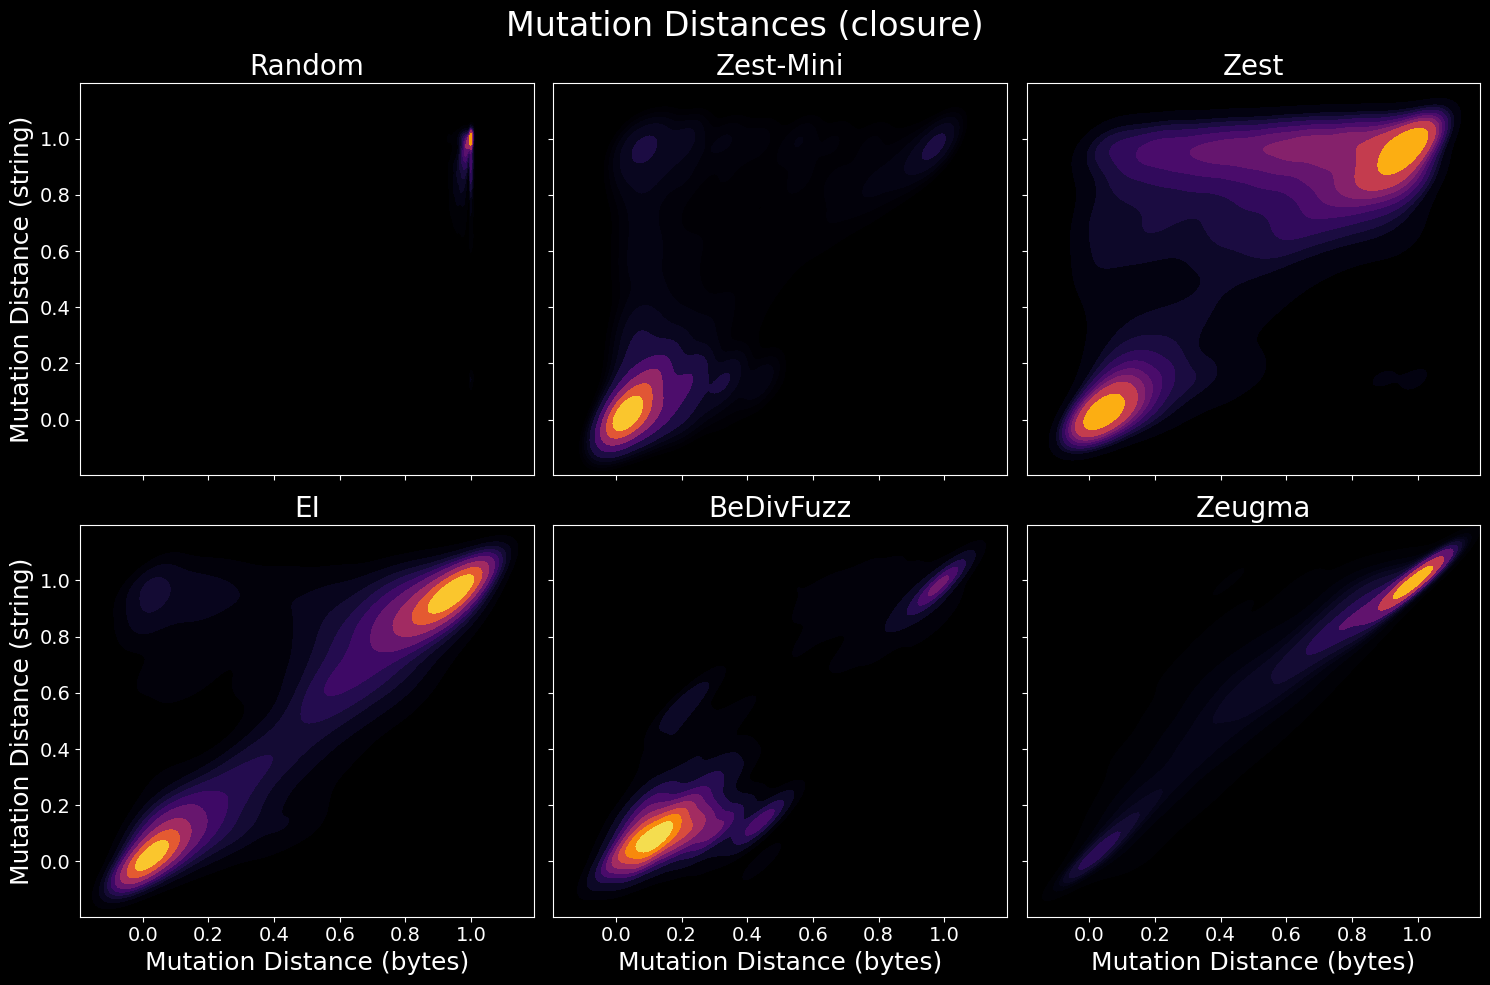

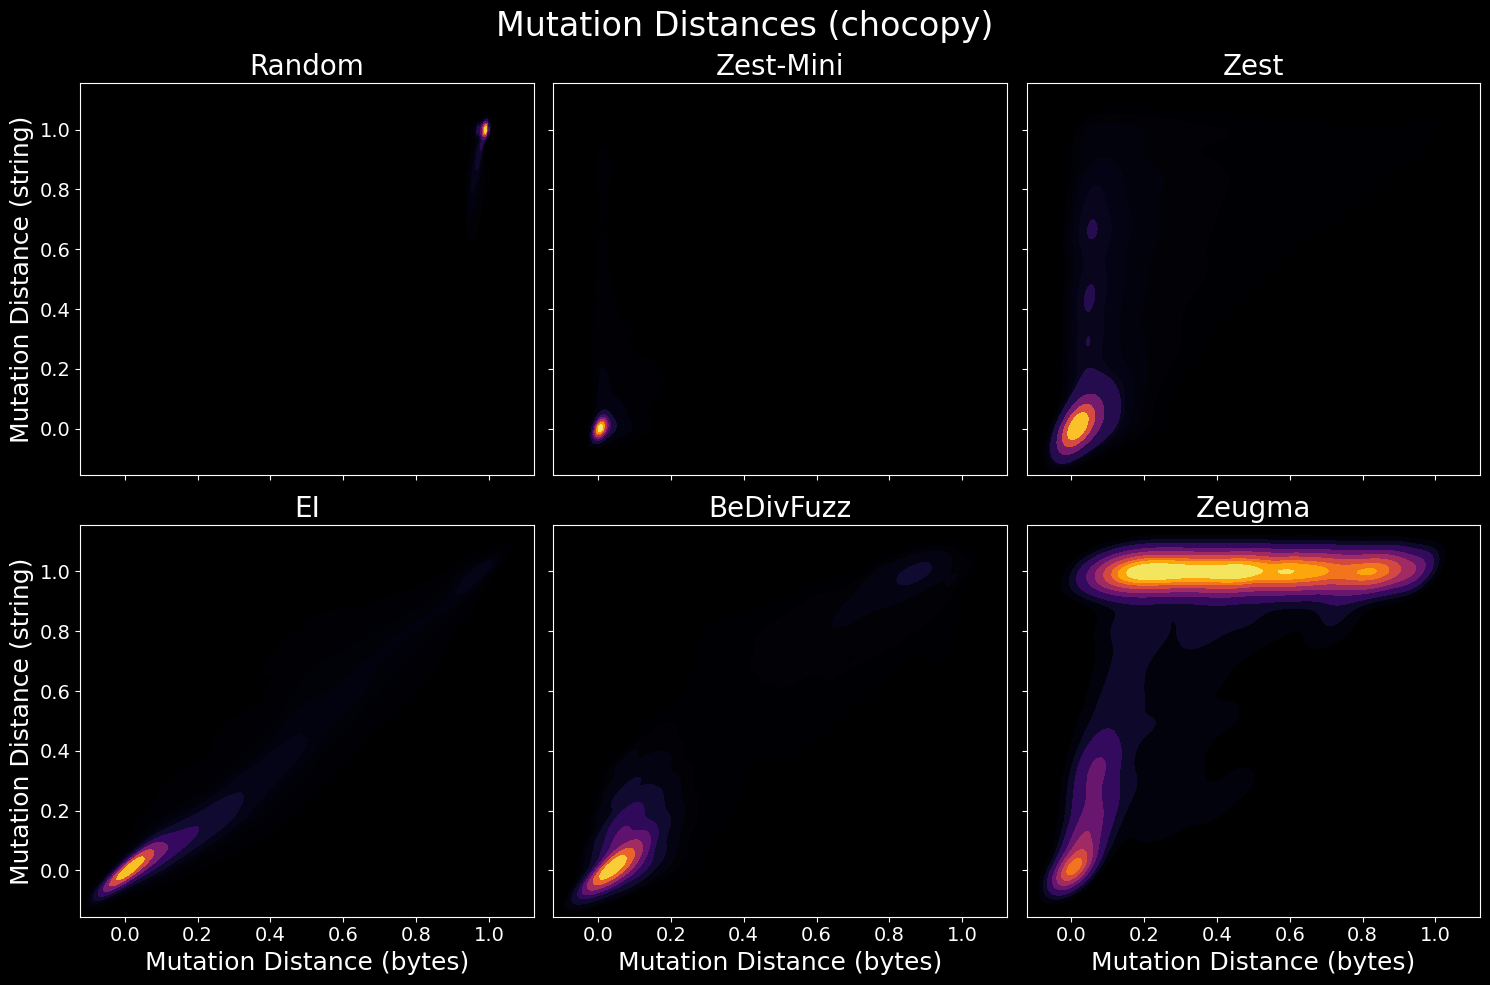

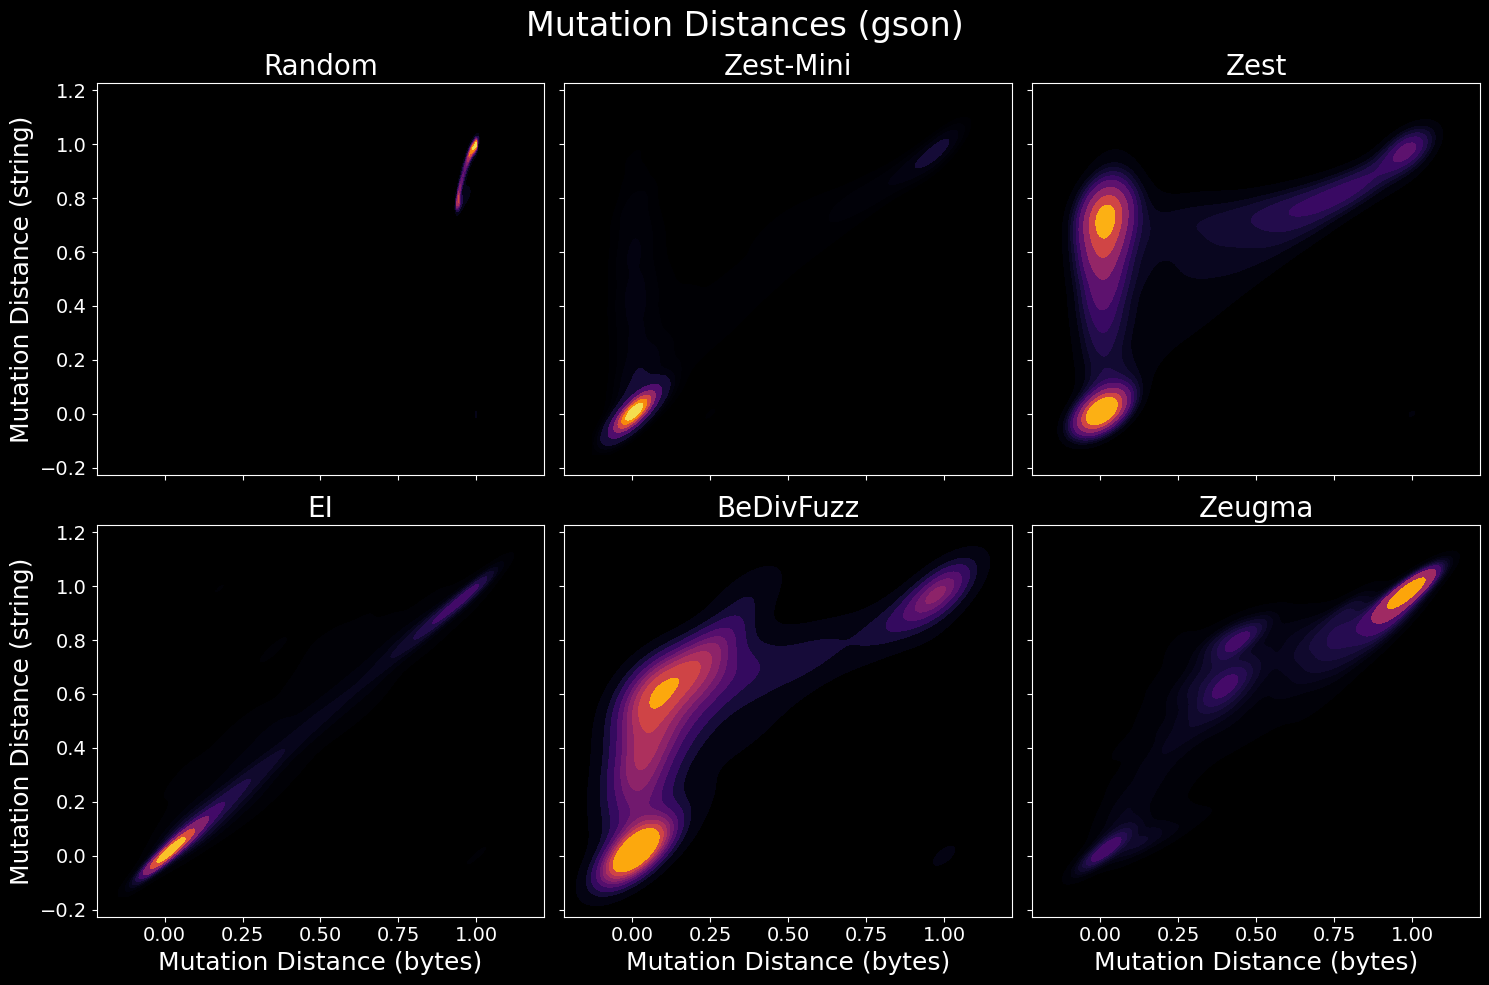

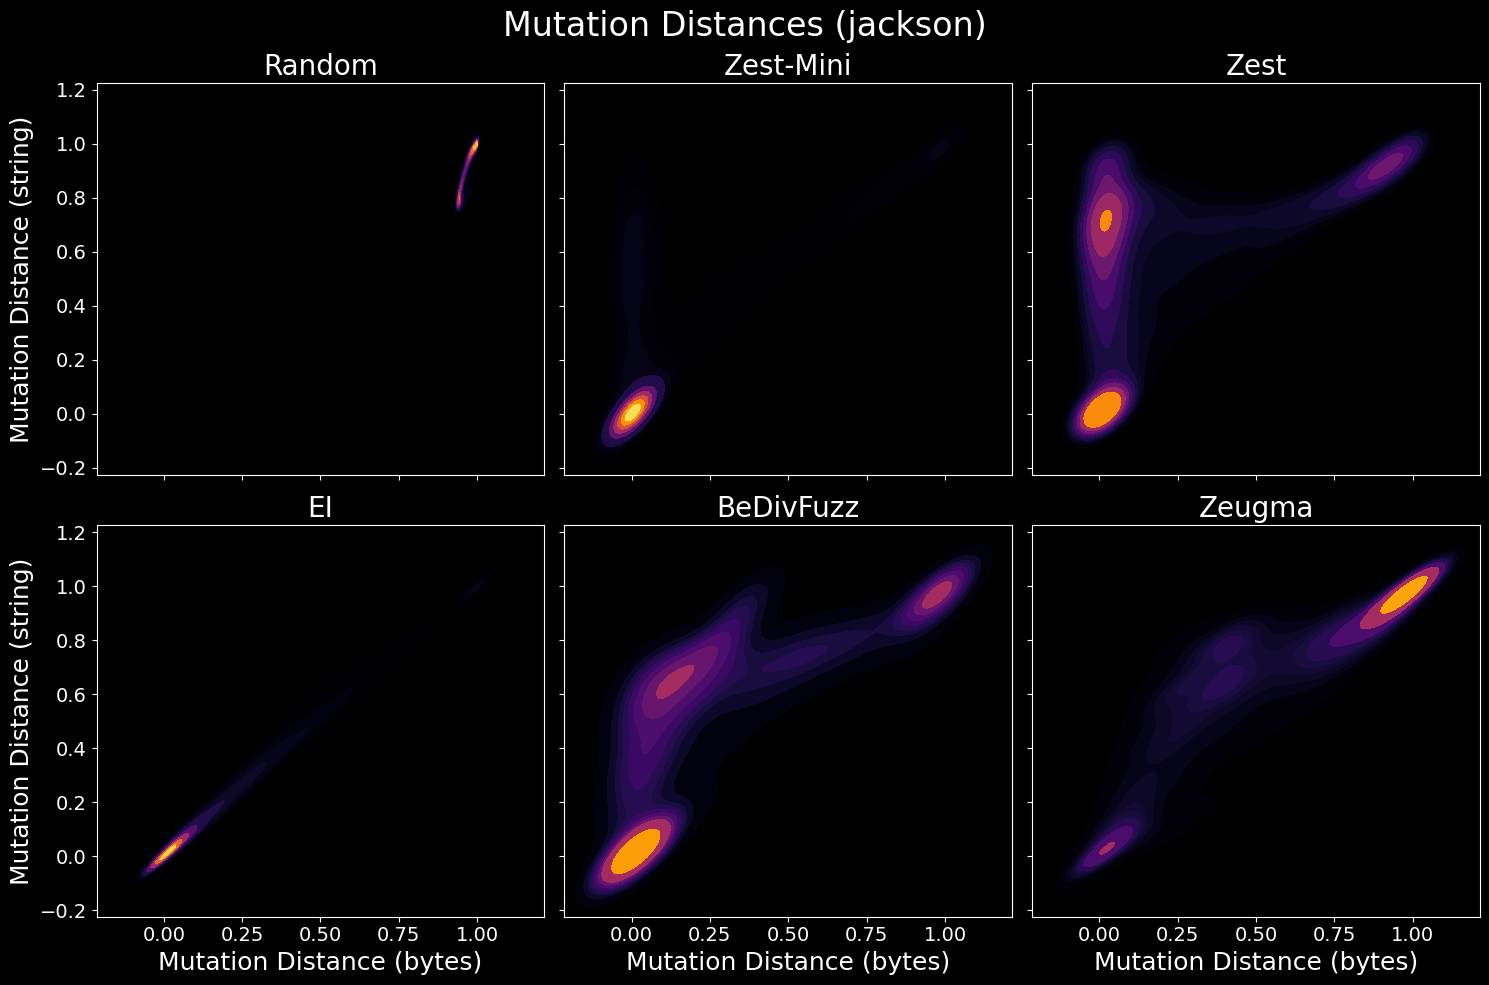

In [63]:
def plot_mut_distance_kde(df, benchmark_name):
    """
    Create 2D KDE heatmaps of mutation distances for each algorithm with a black background.

    Parameters:
    df (pandas.DataFrame): DataFrame containing mutation data with columns:
        - mutation_bytes
        - mutation_string
        - algorithm
        - benchmark_name
    benchmark_name (str): Name of the benchmark to plot

    Returns:
    matplotlib.figure.Figure: The generated plot
    """
    # Set dark background style
    plt.style.use("dark_background")

    # Filter data for the specified benchmark
    plot_data = df[df['benchmark_name'] == benchmark_name].copy()
    
    # Get unique algorithms
    algorithms = plot_data['algorithm'].unique()
    num_algorithms = len(algorithms)

    # Create subplots
    # fig, axes = plt.subplots(1, num_algorithms, figsize=(5 * num_algorithms, 5), sharex=True, sharey=True)

    if num_algorithms == 1:
        axes = [axes]  # Ensure iterable for a single plot

        # Calculate rows and columns for the subplots
    rows = 2
    cols = 3
    
    # Create subplots with 2 rows and 3 columns
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)

    fig.suptitle(f'Mutation Distances ({benchmark_name})', fontsize=24, y=0.98, color='white')

    
    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    # Plot each algorithm separately with a different color
    for i, (algo, color) in enumerate(zip(algorithms, palette)):
        if i < len(axes):  # Ensure we don't go beyond available axes
            ax = axes[i]
            ax.grid(False)
            algo_data = plot_data[plot_data['algorithm'] == algo]
            sns.kdeplot(
                data=algo_data,
                x="mutation_bytes",
                y="mutation_string",
                fill=True,  # Color the heatmap
                cmap="inferno",  # Works well with dark backgrounds
                thresh=0.05,  # Control density threshold
                ax=ax
            )
            ax.set_title(f'{algo}', fontsize=20)  # Title in matching color
            ax.set_xlabel('Mutation Distance (bytes)', fontsize=18)
            ax.set_ylabel('Mutation Distance (string)', fontsize=18)
            ax.xaxis.set_tick_params(labelsize=14)
            ax.yaxis.set_tick_params(labelsize=14)
            ax.tick_params(colors='white')

    
    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    # Adjust layout
    plt.tight_layout()
    return fig

# Loop over all benchmarks and generate the plots
for benchmark in tqdm.tqdm(all_input_df_nonzero_len['benchmark_name'].unique()):
    fig = plot_mut_distance_kde(all_input_df, benchmark)
    plt.savefig(f"figs/heatmap/mutation_distance_kde_{benchmark}.pdf", dpi=300, bbox_inches='tight')

Note: you may need to restart the kernel to use updated packages.


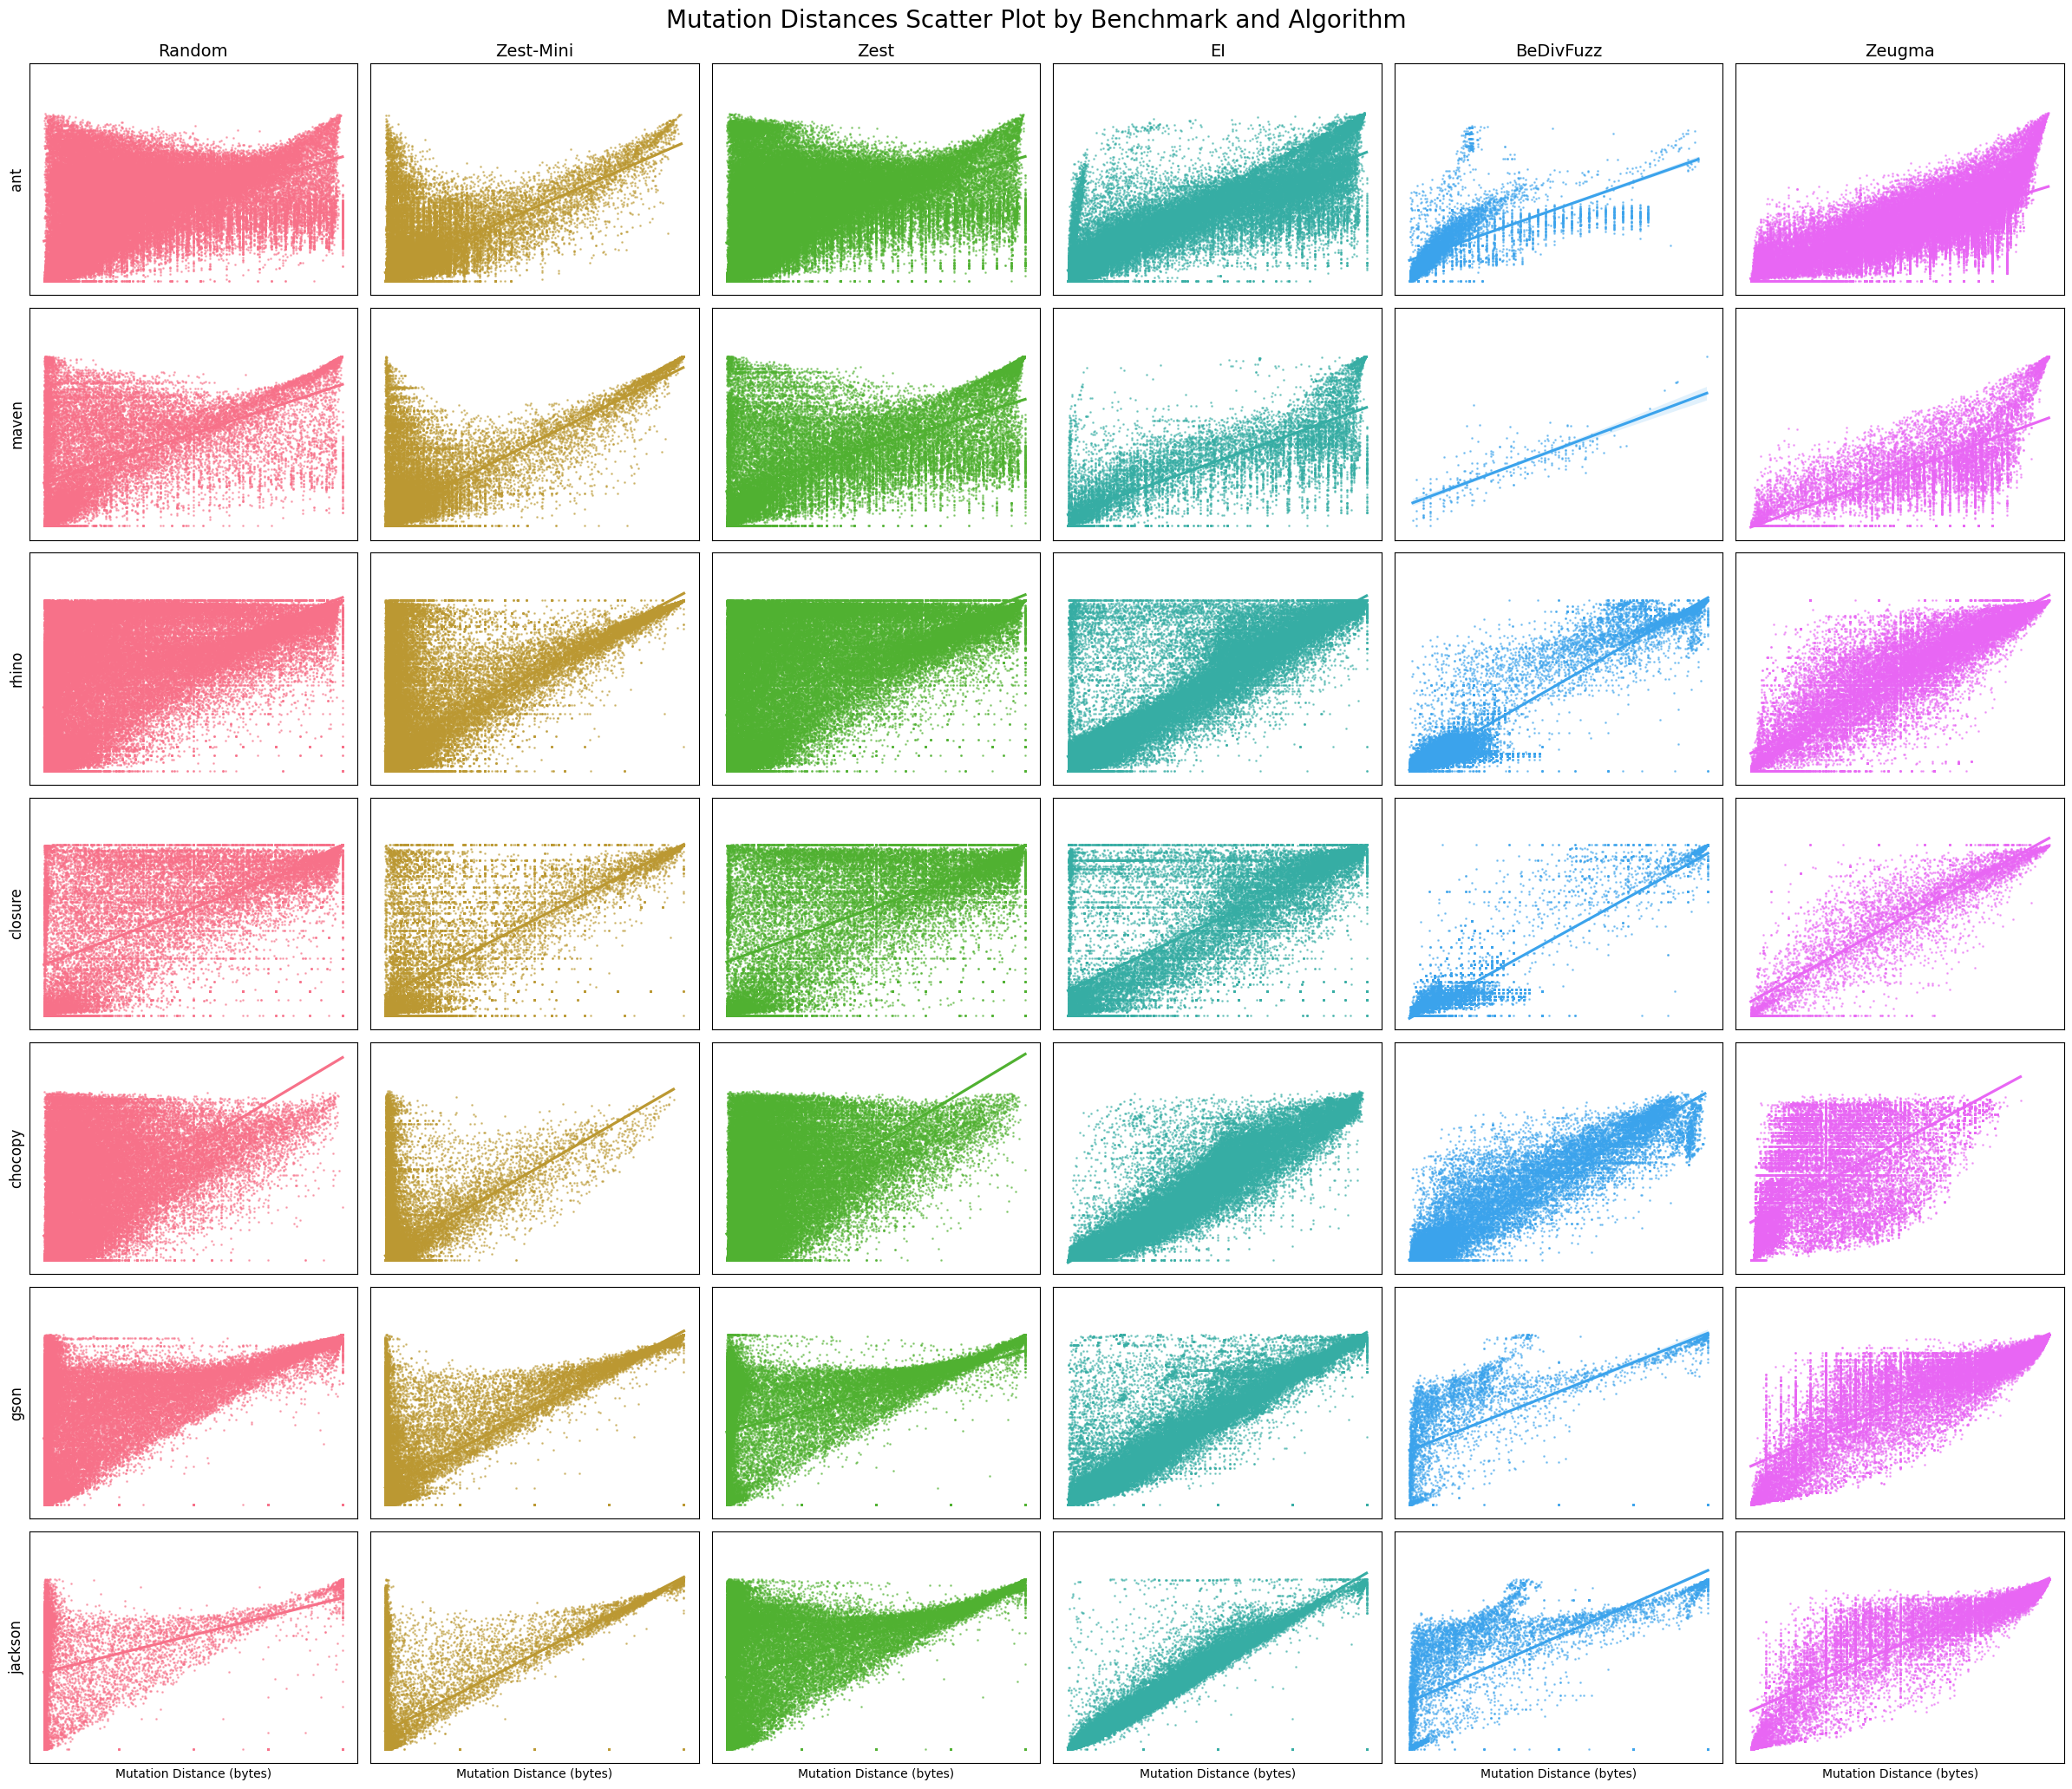

In [208]:
def plot_mutation_distances(df, plot_type='kde', dark_bg=True, individual_benchmarks=False):
    """
    Create a grid of plots showing mutation distances with benchmarks as rows and algorithms as columns.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing mutation data with columns:
        - mutation_bytes
        - mutation_string
        - algorithm
        - benchmark_name
    plot_type (str): Type of plot to create - 'kde' or 'scatter'
    dark_bg (bool): Whether to use a dark background (True) or default style (False)
    individual_benchmarks (bool): Whether to generate individual plots for each benchmark
    
    Returns:
    dict: Dictionary of generated figures, with 'all' for the combined plot and benchmark names for individual plots
    """
    # Set plotting style
    if dark_bg and plot_type == 'kde':
        plt.style.use("dark_background")
    else:
        plt.style.use("default")
    
    # Get unique benchmarks and algorithms
    benchmarks = df['benchmark_name'].unique()
    algorithms = df['algorithm'].unique()
    
    num_benchmarks = len(benchmarks)
    num_algorithms = len(algorithms)
    
    # Define color palette
    if plot_type == 'kde':
        palette = sns.color_palette("Set2", num_algorithms)
    else:
        palette = sns.color_palette("husl", num_algorithms)
    
    # Dictionary to store all generated figures
    figures = {}
    
    # Function to create a single plot (either for combined or individual benchmark)
    def create_plot(plot_df, plot_benchmarks):
        local_num_benchmarks = len(plot_benchmarks)
        
        # Create subplots grid
        fig, axes = plt.subplots(
            local_num_benchmarks, 
            num_algorithms, 
            figsize=(4 * num_algorithms, 3 * local_num_benchmarks), 
            sharex=True, 
            sharey=True
        )
        
        # If only one benchmark or algorithm, ensure axes is a 2D array
        if local_num_benchmarks == 1:
            axes = np.array([axes])
        if num_algorithms == 1:
            axes = axes.reshape(-1, 1)
        
        # Plot each benchmark/algorithm combination
        for i, benchmark in enumerate(plot_benchmarks):
            for j, algo in enumerate(algorithms):
                # Select the data for this benchmark/algorithm combination
                subset_data = plot_df[(plot_df['benchmark_name'] == benchmark) & (plot_df['algorithm'] == algo)]
                
                # Skip if no data for this combination
                if len(subset_data) == 0:
                    text_color = 'white' if dark_bg and plot_type == 'kde' else 'black'
                    axes[i, j].text(0.5, 0.5, "No Data", ha='center', va='center', fontsize=12, color=text_color)
                    continue
                
                # Create the specified plot type
                if plot_type == 'kde':
                    sns.kdeplot(
                        data=subset_data,
                        x="mutation_bytes",
                        y="mutation_string",
                        fill=True,
                        cmap="inferno" if dark_bg else "viridis",
                        thresh=0.05,
                        ax=axes[i, j]
                    )
                else:  # scatter plot
                    sns.regplot(
                        data=subset_data,
                        x='mutation_bytes',
                        y='mutation_string',
                        scatter=True,
                        scatter_kws={'s': 1, 'alpha': 0.5, 'color': palette[j]},
                        line_kws={'color': palette[j]},
                        ci=95,
                        ax=axes[i, j]
                    )
                
                # Set title and format axes
                if i == 0:  # Only show algorithm names on the top row
                    axes[i, j].set_title(f'{algo}', fontsize=14)
                
                if j == 0:  # Only show benchmark names on the leftmost column
                    axes[i, j].set_ylabel(f'{benchmark}', fontsize=12)
                else:
                    axes[i, j].set_ylabel('')
                
                # Only show x-axis labels on the bottom row
                if i == local_num_benchmarks - 1:
                    axes[i, j].set_xlabel('Mutation Distance (bytes)', fontsize=10)
                else:
                    axes[i, j].set_xlabel('')
                
                # Customize tick parameters
                text_color = 'white' if dark_bg and plot_type == 'kde' else 'black'
                axes[i, j].tick_params(colors=text_color, labelsize=8)
                
                # Only show y-axis ticks on the leftmost column
                if j > 0:
                    axes[i, j].set_yticks([])
                
                # Only show x-axis ticks on the bottom row
                if i < local_num_benchmarks - 1:
                    axes[i, j].set_xticks([])
        
        # Add a main title
        plot_type_name = "Heatmap" if plot_type == 'kde' else "Scatter Plot"
        if len(plot_benchmarks) == 1:
            title = f'Mutation Distances {plot_type_name} ({plot_benchmarks[0]})'
        else:
            title = f'Mutation Distances {plot_type_name} by Benchmark and Algorithm'
        
        text_color = 'white' if dark_bg and plot_type == 'kde' else 'black'
        fig.suptitle(title, fontsize=20, y=0.98, color=text_color)
        
        # Adjust layout
        plt.tight_layout()
        plt.subplots_adjust(top=0.95)  # Make room for the title
        
        return fig
    
    # Generate combined plot with all benchmarks
    figures['all'] = create_plot(df, benchmarks)
    
    # Generate individual benchmark plots if requested
    if individual_benchmarks:
        for benchmark in benchmarks:
            benchmark_df = df[df['benchmark_name'] == benchmark]
            figures[benchmark] = create_plot(benchmark_df, [benchmark])
    
    return figures

# Example usage:
# Save the combined plot with all benchmarks (as KDE heatmap)
plot_type = "scatter"
figs = plot_mutation_distances(all_input_df_nonzero_len, plot_type=plot_type)
plot_type_name = "heatmap" if plot_type == 'kde' else "scatter"
plt.figure(figs['all'].number)
plt.savefig(f"figs/{plot_type_name}/all_mutation_distance_{plot_type_name}.pdf", dpi=300, bbox_inches='tight')

# # Generate individual benchmark plots
# figs = plot_mutation_distances(all_input_df_nonzero_len, plot_type='scatter', dark_bg=False, individual_benchmarks=True)
# for benchmark, fig in figs.items():
#     if benchmark != 'all':
#         plt.figure(fig.number)
#         plt.savefig(f"figs/scatter/mutation_distance_scatter_{benchmark}.pdf", dpi=300, bbox_inches='tight')

# # You can also generate KDE plots for individual benchmarks
# figs = plot_mutation_distances(all_input_df_nonzero_len, plot_type='kde', dark_bg=True, individual_benchmarks=True)
# for benchmark, fig in figs.items():
#     if benchmark != 'all':
#         plt.figure(fig.number)
#         plt.savefig(f"figs/heatmap/mutation_distance_kde_{benchmark}.pdf", dpi=300, bbox_inches='tight')

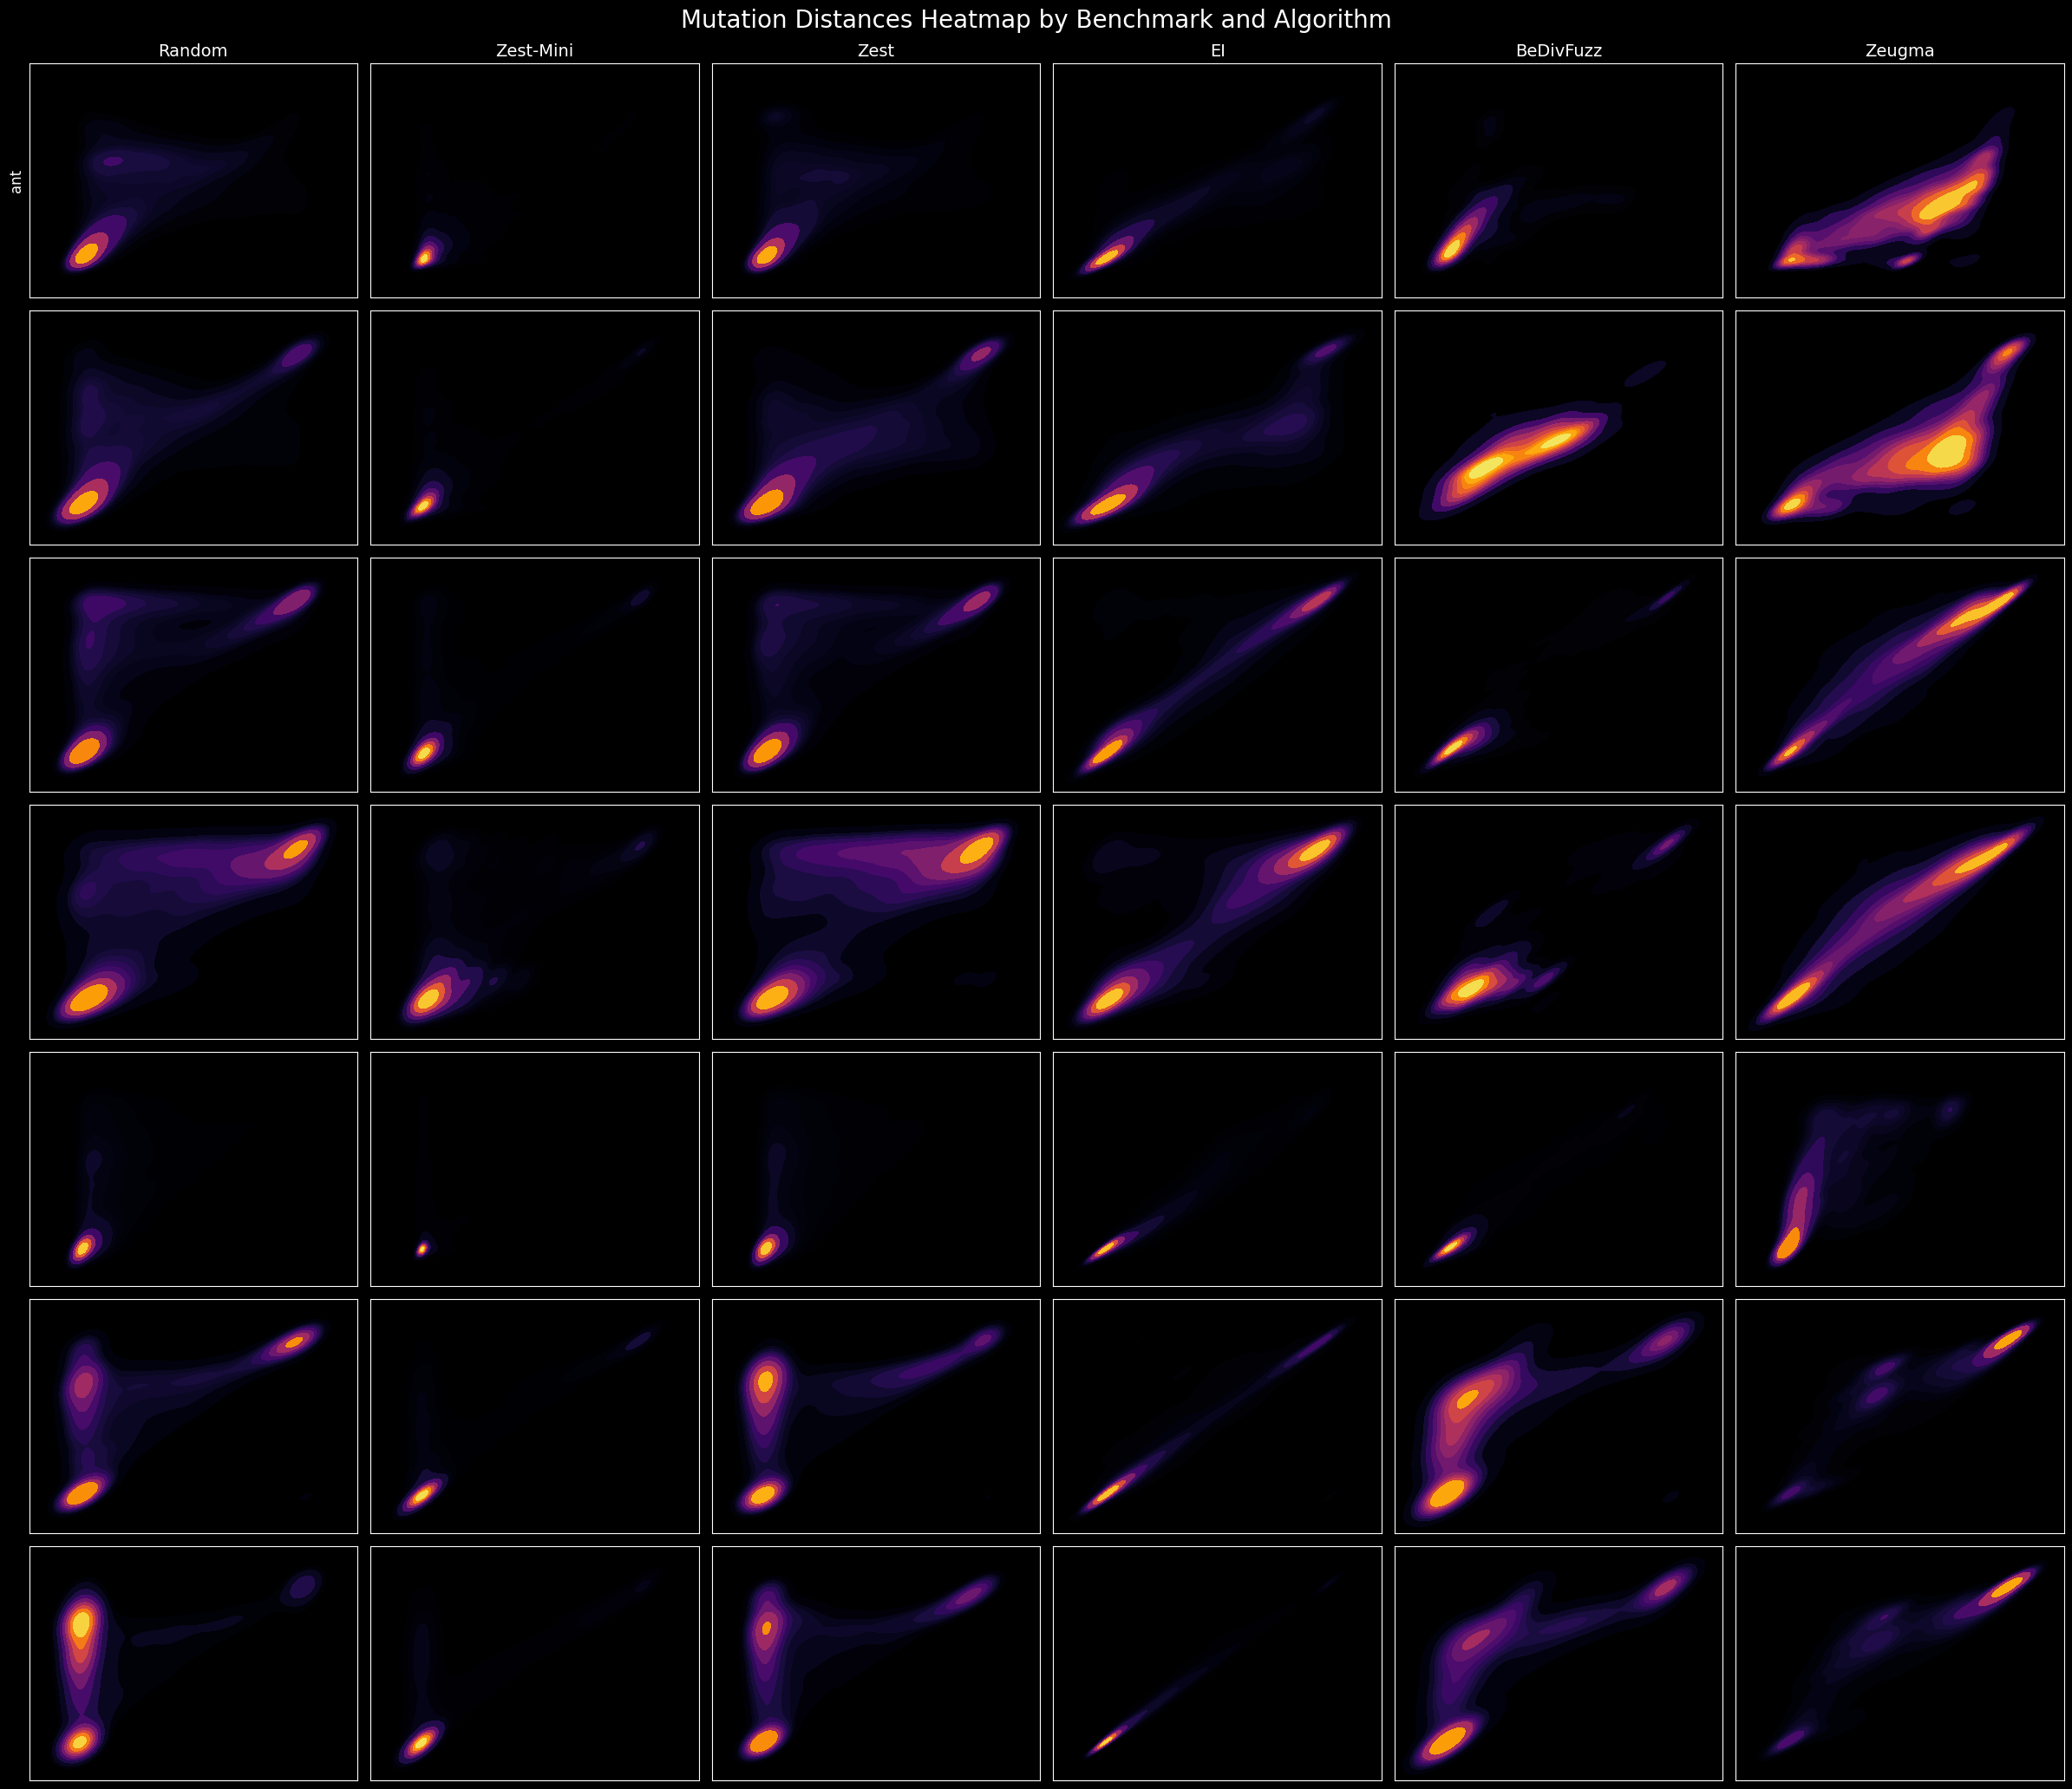

In [209]:
plot_type = "kde"
figs = plot_mutation_distances(all_input_df_nonzero_len, plot_type=plot_type)
plot_type_name = "heatmap" if plot_type == 'kde' else "scatter"
plt.figure(figs['all'].number)
plt.savefig(f"figs/{plot_type_name}/all_mutation_distance_{plot_type_name}.pdf", dpi=300, bbox_inches='tight')


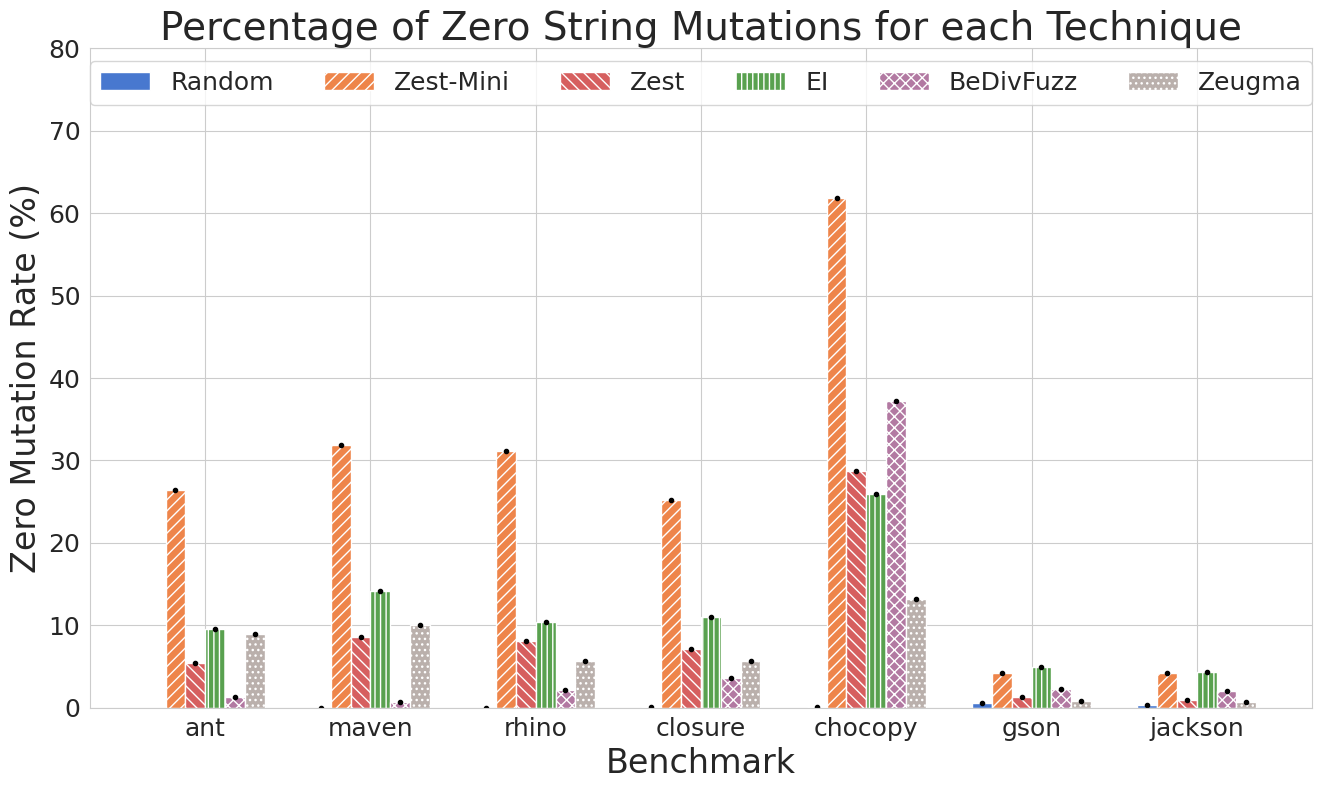

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_zero_mutation_plot(df):
    # Set the style to match the example
    sns.set_style("whitegrid")
    
    # Filter to include only rows where parent_result == 'SUCCESS'
    filtered_df = df[df['parent_result'] == 'SUCCESS']
    
    # Calculate the percentage of zero mutations for each benchmark and algorithm
    zero_rates = []
    for benchmark in filtered_df['benchmark_name'].unique():
        benchmark_df = filtered_df[filtered_df['benchmark_name'] == benchmark]
        
        for algorithm in benchmark_df['algorithm'].unique():
            algo_df = benchmark_df[benchmark_df['algorithm'] == algorithm]
            
            # Calculate zero mutation rate
            total_rows = len(algo_df)
            zero_rows = len(algo_df[algo_df['mutation_string'] == 0])
            
            if total_rows > 0:
                zero_rate = zero_rows / total_rows * 100
            else:
                zero_rate = 0
                
            zero_rates.append({
                'benchmark_name': benchmark,
                'algorithm': algorithm,
                'zero_rate': zero_rate,
                'total_rows': total_rows,
                'zero_rows': zero_rows
            })
    
    # Convert to DataFrame
    zero_df = pd.DataFrame(zero_rates)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Get unique benchmarks and use the specified algorithm order
    benchmarks = zero_df['benchmark_name'].unique()
    algorithms = ["Random", "Zest-Mini", "Zest", "EI", "BeDivFuzz", "Zeugma"]
    
    # Set up the positions for grouped bars
    x = np.arange(len(benchmarks))
    width = 0.12  # Width of each bar
    
    # Define hatching patterns for bars (similar to the example)
    hatches = ['', '///', '\\\\\\', '|||', 'xxx', '...']
    
    # Define color palette (adjust to match example more closely)
    colors = ['#4878CF', '#EE854A', '#D65F5F', '#59A14F', '#B279A2', '#BAB0AC']
    
    # Plot each algorithm group
    for i, algorithm in enumerate(algorithms):
        if algorithm in zero_df['algorithm'].values:
            mask = zero_df['algorithm'] == algorithm
            values = [zero_df[mask & (zero_df['benchmark_name'] == b)]['zero_rate'].values[0] 
                     if any(mask & (zero_df['benchmark_name'] == b)) else 0 
                     for b in benchmarks]
            
            bars = ax.bar(x + (i - 2.5) * width, values, width, 
                   label=algorithm, color=colors[i])
            
            # Add hatching to bars
            for bar, hatch in zip(bars, [hatches[i]] * len(bars)):
                bar.set_hatch(hatch)
                
            # Add data points on top of bars
            for j, val in enumerate(values):
                if val > 0:  # Only add points for non-zero values
                    ax.plot(x[j] + (i - 2.5) * width, val, 'o', color='black', markersize=3)
    
    # Customize the plot
    ax.set_xticks(x)
    ax.set_xticklabels(benchmarks)
    ax.set_xlabel('Benchmark', fontsize=24)
    ax.set_ylabel('Zero Mutation Rate (%)', fontsize=24)
    ax.set_title('Percentage of Zero String Mutations for each Technique', fontsize=28)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)
    
    # Add benchmark counts like in the example (ChocoPy (4856), etc.)
    benchmark_counts = {}
    for benchmark in benchmarks:
        count = len(filtered_df[filtered_df['benchmark_name'] == benchmark])
        benchmark_counts[benchmark] = count
    
    # labels_with_counts = [f"{b}\n({benchmark_counts[b]})" for b in benchmarks]
    # ax.set_xticklabels(labels_with_counts)
    
    # Set y-axis limits
    ax.set_ylim(0, 80)  # Set to 105 to leave room for data points at the top
    
    # Add a legend
    ax.legend(loc='upper center', 
              ncol=len(algorithms), frameon=True, fontsize=18)
    
    plt.tight_layout()
    return plt, zero_df

# Usage:
plt, zero_mutation_data = create_zero_mutation_plot(all_input_df_nonzero_len)
plt.savefig("figs/zero_mutations.pdf", bbox_inches='tight')

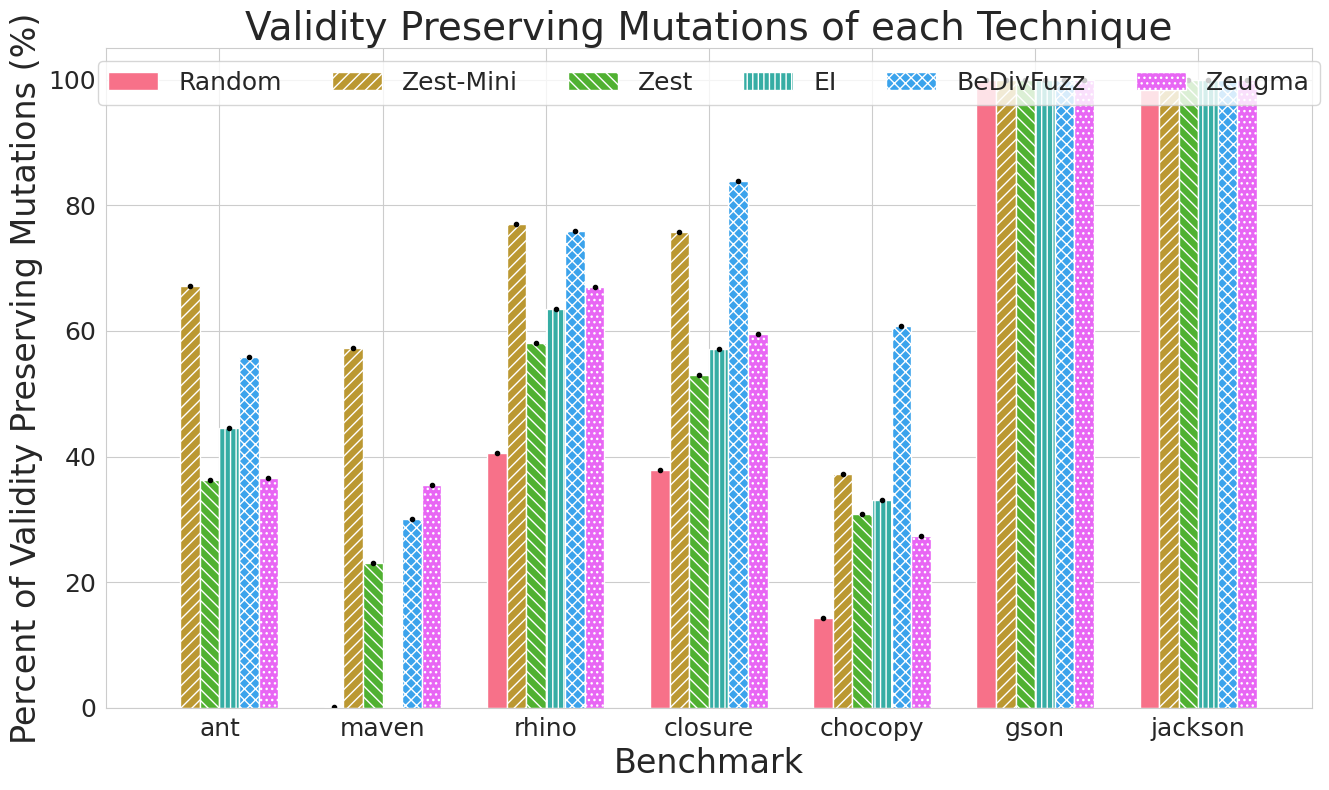

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_success_rate_chart(df, filter_zero=True):
    # Set the style to match the example
    sns.set_style("whitegrid")
    
    # Filter to include only rows where parent_result == 'SUCCESS'
    filtered_df = df[df['parent_result'] == 'SUCCESS']

    if filter_zero:
        filtered_df = filtered_df[filtered_df["mutation_string"] != 0]
    
    # Calculate the success rate for each benchmark and algorithm
    success_rates = []
    for benchmark in filtered_df['benchmark_name'].unique():
        benchmark_df = filtered_df[filtered_df['benchmark_name'] == benchmark]
        
        for algorithm in benchmark_df['algorithm'].unique():
            algo_df = benchmark_df[benchmark_df['algorithm'] == algorithm]
            
            # Calculate success rate
            total_rows = len(algo_df)
            success_rows = len(algo_df[algo_df['result'] == 'SUCCESS'])
            
            if total_rows > 0:
                success_rate = success_rows / total_rows * 100
            else:
                success_rate = 0
                
            success_rates.append({
                'benchmark_name': benchmark,
                'algorithm': algorithm,
                'success_rate': success_rate,
                'total_rows': total_rows,
                'success_rows': success_rows
            })
    
    # Convert to DataFrame
    success_df = pd.DataFrame(success_rates)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Get unique benchmarks and algorithms
    # benchmarks = ['ant', 'maven', 'rhino', 'closure']
    benchmarks = df['benchmark_name'].unique()
    algorithms = ["Random", "Zest-Mini", "Zest", "EI", "BeDivFuzz", "Zeugma"]
    
    # Set up the positions for grouped bars
    x = np.arange(len(benchmarks))
    width = 0.12  # Width of each bar
    
    # Define hatching patterns for bars (similar to the example)
    hatches = ['', '///', '\\\\\\', '|||', 'xxx', '...']
    
    # Define color palette (adjust to match example more closely)
    colors = ['#4878CF', '#EE854A', '#D65F5F', '#59A14F', '#B279A2', '#BAB0AC']
    
    # Plot each algorithm group
    for i, algorithm in enumerate(algorithms):
        if algorithm in success_df['algorithm'].values:
            mask = success_df['algorithm'] == algorithm
            values = [success_df[mask & (success_df['benchmark_name'] == b)]['success_rate'].values[0] 
                     if any(mask & (success_df['benchmark_name'] == b)) else 0 
                     for b in benchmarks]
            
            bars = ax.bar(x + (i - 2.5) * width, values, width, 
                   label=algorithm, color=colors[i])
            
            # Add hatching to bars
            for bar, hatch in zip(bars, [hatches[i]] * len(bars)):
                bar.set_hatch(hatch)
                
            # Add data points on top of bars
            for j, val in enumerate(values):
                if val > 0:  # Only add points for non-zero values
                    ax.plot(x[j] + (i - 2.5) * width, val, 'o', color='black', markersize=3)
    
    # Customize the plot
    ax.set_xticks(x)
    ax.set_xticklabels(benchmarks)
    ax.set_xlabel('Benchmark', fontsize=24)
    ax.set_ylabel('Percent of Validity Preserving Mutations (%)', fontsize=24)
    ax.set_title('Validity Preserving Mutations of each Technique', fontsize=28)
    
    # Add benchmark counts like in the example (ChocoPy (4856), etc.)
    benchmark_counts = {}
    for benchmark in benchmarks:
        count = len(filtered_df[filtered_df['benchmark_name'] == benchmark])
        benchmark_counts[benchmark] = count
    
    labels_with_counts = [f"{b}\n({benchmark_counts[b]})" for b in benchmarks]
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)
    
    # Set y-axis limits
    ax.set_ylim(0, 105)  # Set to 105 to leave room for data points at the top
    
    # Add a legend
    ax.legend(loc='upper center', 
              ncol=len(algorithms), frameon=True, fontsize=18)
    
    plt.tight_layout()
    return plt, success_df

# Usage:
plt, success_data = create_success_rate_chart(all_input_df_nonzero_len)
plt.savefig("figs/mutation_validity.pdf", bbox_inches='tight')

In [179]:
all_input_df_nonzero_len[(all_input_df_nonzero_len["algorithm"] == "Zeugma") & (all_input_df_nonzero_len["result"] == "FAILURE")]

mutation_bytes  mutation_string algorithm  current_len  parent_len  \
1421984        0.201613         0.366667    Zeugma           81          90   
1422476        0.049180         0.048193    Zeugma           83          81   
1424316        0.000000         0.000000    Zeugma           83          83   
1424536        0.068376         0.048193    Zeugma           82          83   
1425472        0.000000         0.000000    Zeugma           82          82   
...                 ...              ...       ...          ...         ...   
1456062        0.521127         0.560976    Zeugma           41          21   
1456426        0.613208         0.725000    Zeugma           80          25   
1457117        0.622807         0.690141    Zeugma           71          30   
1457756        0.654545         0.724138    Zeugma           29          11   
1458487        0.045455         0.080000    Zeugma           25          25   

         saved  parent   result parent_result benchmark_name  
1421984   True    8321  FAILURE       SUCCESS          rhino  
1422476   True   10359  FAILURE       FAILURE          rhino  
1424316  False   10853  FAILURE       FAILURE          rhino  
1424536   True   10853  FAILURE       FAILURE          rhino  
1425472  False   12917  FAILURE       FAILURE          rhino  
...        ...     ...      ...           ...            ...  
1456062  False   29011  FAILURE       SUCCESS          rhino  
1456426  False   36789  FAILURE       FAILURE          rhino  
1457117  False   44950  FAILURE       SUCCESS          rhino  
1457756  False    5313  FAILURE       SUCCESS          rhino  
1458487  False   36789  FAILURE       FAILURE          rhino  

[69 rows x 10 columns]

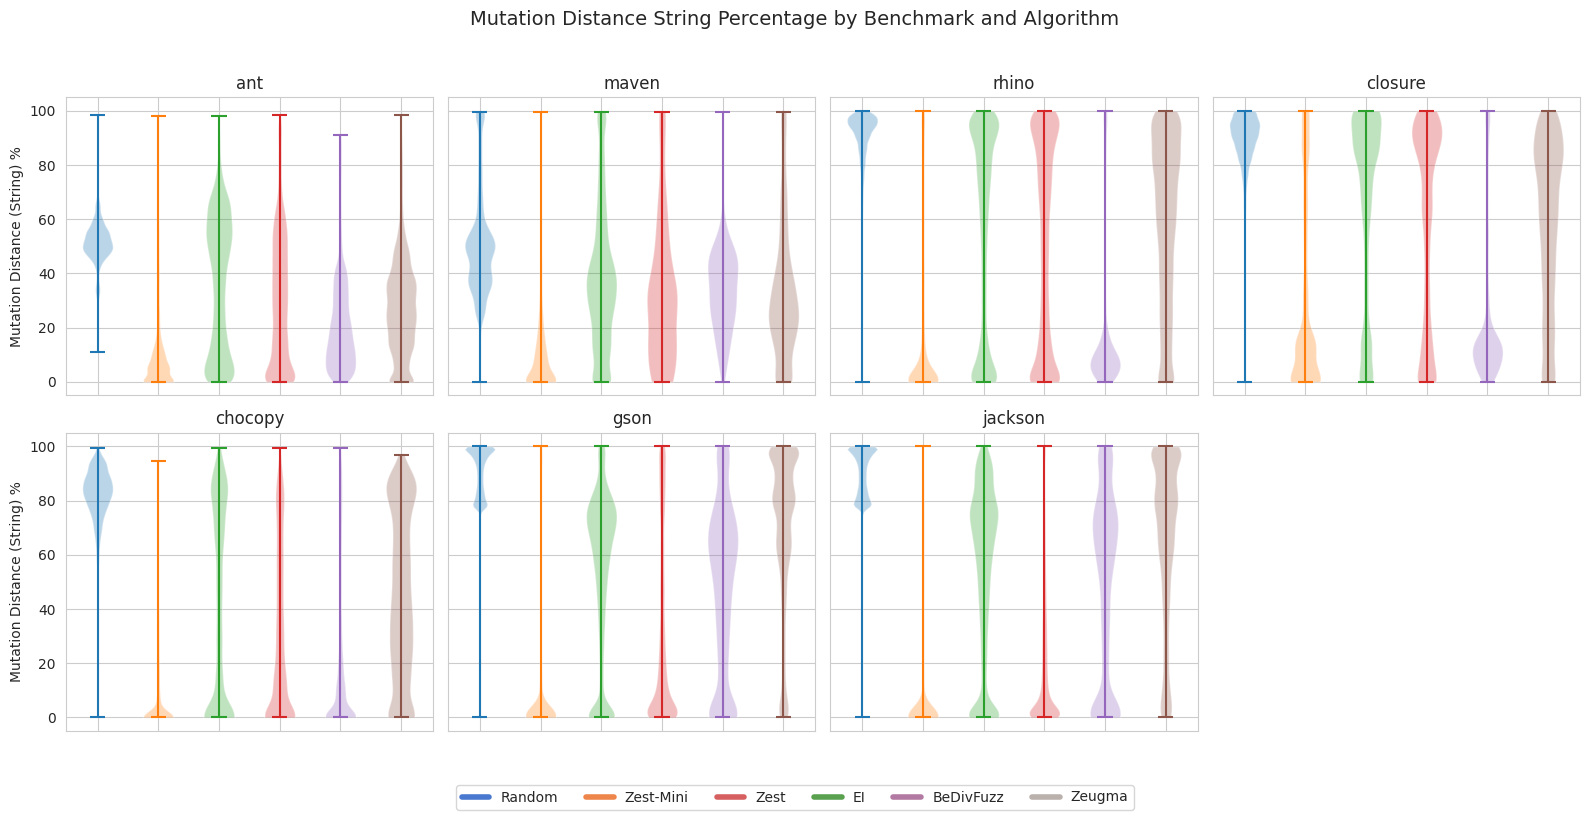

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_compact_violin_plots(df):
    # Define algorithm order
    algorithms = ["Random", "Zest-Mini", "Zest", "EI", "BeDivFuzz", "Zeugma"]
    
    # Define colors for algorithms (matching bar plot)
    colors = ['#4878CF', '#EE854A', '#D65F5F', '#59A14F', '#B279A2', '#BAB0AC']
    algo_colors = dict(zip(algorithms, colors))
    
    # Filter to include only rows where parent_result == 'SUCCESS'
    filtered_df = df[df['parent_result'] == 'SUCCESS'].copy()
    
    # Create mutation_string_pct column (multiplied by 100)
    filtered_df['mutation_string_pct'] = filtered_df['mutation_string'] * 100
    
    # Get benchmarks
    benchmarks = filtered_df['benchmark_name'].unique()
    
    # Calculate layout (2 rows, with benchmarks divided between them)
    n_benchmarks = len(benchmarks)
    cols_per_row = int(np.ceil(n_benchmarks / 2))
    
    # Set up figure
    fig, axes = plt.subplots(2, cols_per_row, figsize=(4*cols_per_row, 8), sharey=True)
    axes = axes.flatten()  # Flatten for easier indexing
    
    # For each benchmark, create a subplot with violins for each algorithm
    for i, benchmark in enumerate(benchmarks):
        ax = axes[i]
        benchmark_df = filtered_df[filtered_df['benchmark_name'] == benchmark]
        
        # Plot each algorithm as a separate violin
        positions = range(len(algorithms))
        for j, algorithm in enumerate(algorithms):
            algo_df = benchmark_df[benchmark_df['algorithm'] == algorithm]
            
            if not algo_df.empty:
                # Create violin plot for this algorithm
                parts = ax.violinplot(
                    [algo_df['mutation_string_pct']], 
                    positions=[j],
                )
                
                # Set violin color
                # for pc in parts['bodies']:
                #     pc.set_facecolor(algo_colors[algorithm])
                #     pc.set_alpha(0.7)
                
                # # Add small box plot for the median
                # ax.boxplot(
                #     [algo_df['mutation_string_pct']], 
                #     positions=[j], 
                #     widths=0.3, 
                #     showcaps=False,
                #     showfliers=False,
                #     medianprops={'color': 'black'},
                #     boxprops={'color': 'black', 'facecolor': 'none'},
                #     whiskerprops={'color': 'none'}
                # )
        
        # Set subplot title and labels
        ax.set_title(benchmark, fontsize=12)
        # ax.set_xticks(range(len(algorithms)))
        ax.set_xticklabels([])  # Abbreviate names
        
        # Only show y-label on leftmost plots
        if i % cols_per_row == 0:
            ax.set_ylabel('Mutation Distance (String) %')
    
    # Remove empty subplots if any
    for i in range(n_benchmarks, len(axes)):
        fig.delaxes(axes[i])
    
    # Add a legend
    handles = [plt.Line2D([0], [0], color=algo_colors[a], lw=4, label=a) for a in algorithms]
    fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 0.02),
              ncol=len(algorithms), frameon=True, fontsize=10)
    
    # Add an overall title
    fig.suptitle('Mutation Distance String Percentage by Benchmark and Algorithm', fontsize=14)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.06, 1, 0.96])  # Make room for title and legend
    return plt

# Usage:
plt = create_compact_violin_plots(all_input_df_nonzero_len)
plt.savefig("violin_plot_mut_distance_string.pdf", bbox_inches='tight')

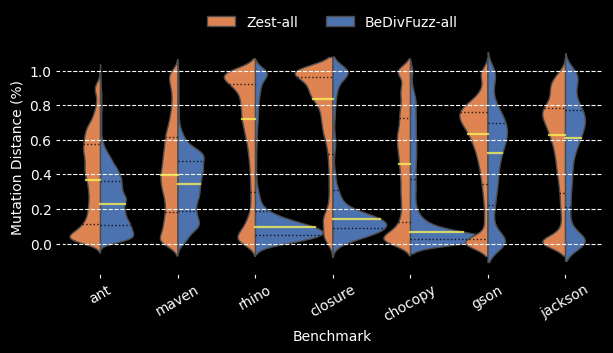

In [14]:
x_order = ('ant', 'maven', 'rhino', 'closure', 'chocopy', 'gson', 'jackson')
zest_versus_bedivfuzz = non_zero_all_input_df[non_zero_all_input_df['algorithm'].str.contains('Zest|BeDivFuzz')]
violin_plot_for_mutation_distance(zest_versus_bedivfuzz, "t1", 'rq2_wo_zero_mutations_2', width=2.0, x_order=x_order)

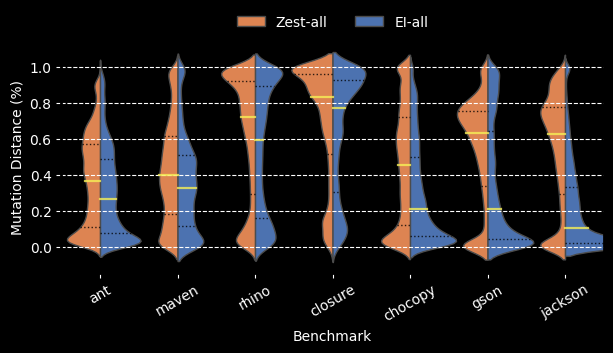

In [15]:
zest_versus_ei = non_zero_all_input_df[non_zero_all_input_df['algorithm'].str.contains('Zest|EI')]
violin_plot_for_mutation_distance(zest_versus_ei, "t1", 'rq2_wo_zero_mutations_2', width=2.0, x_order=x_order)

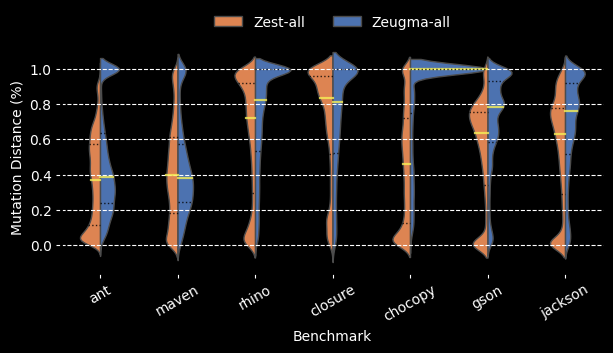

In [16]:
zest_versus_zeugma = non_zero_all_input_df[non_zero_all_input_df['algorithm'].str.contains('Zest|Zeugma')]
violin_plot_for_mutation_distance(zest_versus_zeugma, "t1", 'rq2_wo_zero_mutations_2', width=2.0, x_order=x_order)

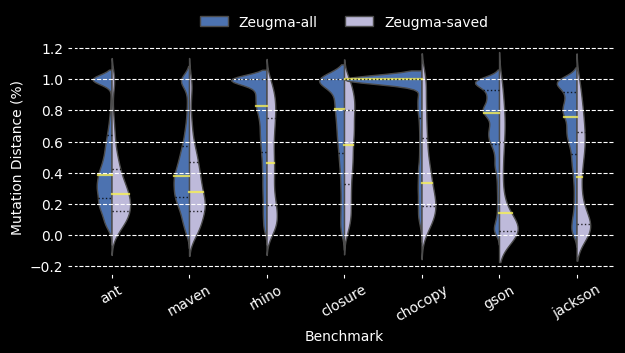

In [17]:
non_zero_zeugma_df = non_zero_mutation_df[non_zero_mutation_df['algorithm'].str.contains('Zeugma')]
violin_plot_for_mutation_distance(non_zero_zeugma_df, "t1", 'rq2_wo_zero_mutations_2', width=2.0, x_order=x_order)